<a href="https://colab.research.google.com/github/sbmoyano/data_science_projects/blob/master/fraud_detection/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In the current notebook I will train a LSTM model. As our dataset is not too big I will use only one LSTM layer and one Dense output layer.

**MODEL TRAINING**

In order to train this model, I need to split the data into sequences, with each cardholder representing an unique sequence. Moreover, each set (train, test and validation) will contain different sequences and transaction times, with older transactions being used to train the model and the most recent ones to test it.

Similarly to the MLP model, I will compute an initial bias to be considered in the output layer. I will test if including it actually improved model performance. After than, I will try some regularization methods in case I detect that the model could be overfitting.

**THRESHOLDS**

I will again test different decision thresholds to find the one that offers the best results.

**HYPERPARAMETER TUNING**

Once I have the final structure of the model, I will perform hyperparameter tuning using RandomSearch. I will opt for this method as it is faster, and I want reduce searching times due to limitation in GPU use.

**EARLY STOPPING**

Again, I will implement early stopping in case training times increase too much, but also as a regularization technique in case of overfitting. I will focus the early stopping in monitoring validation loss as it offers more variability compared to AUC.


## Install or update libraries for Google Colab

In [ ]:
! pip install optuna
! pip install -q -U keras-tuner
! pip install tensorflow-addons
! pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 21.8 MB/s 
     |████████████████████████████████| 81 kB 4.4 MB/s 
     |████████████████████████████████| 209 kB 45.8 MB/s 
     |████████████████████████████████| 78 kB 3.8 MB/s 
     |████████████████████████████████| 112 kB 52.1 MB/s 
     |████████████████████████████████| 50 kB 2.9 MB/s 
     |████████████████████████████████| 147 kB 61.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=208450c3a0062ac325a3715f94492749b754723f59512ad51a73ea9efbaf7f50
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
     |████████████████████████████████| 135 kB 8.3 MB/s 
     |████████████████████████████████| 1.6 MB 32.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/sim

# Set environment

# Import libraries

In [ ]:
# manage paths
import sys

# Data manipulation
import pandas as pd
import numpy as np
import math
import os
import datetime
import json
import random
from collections import Counter

# Visualization
import seaborn as sns
sns.set_style("white")
sns.set_context("paper")
import matplotlib.pyplot as plt
import shap

# feature engineering
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, auc, RocCurveDisplay
from sklearn.model_selection import cross_val_score

# pipeline
from sklearn.pipeline import Pipeline

# tensorflow
import tensorflow.keras.backend as K
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Dense, Dropout
from keras.constraints import maxnorm
from tensorflow.python.keras.callbacks import TensorBoard
import keras_tuner as kt

# hyperparameter tuning
import optuna
from optuna.samplers import RandomSampler

In [ ]:
device_name = tf.test.gpu_device_name()

if device_name != "/device:GPU:0":
  raise SystemError("GPU device not found")

print("Found GPU at: {}".format(device_name))

# Paths

In [ ]:
# create directories if they do not exist in Jupyter Notebook
models_dir = os.path.join(os.getcwd(), ".models")
scores_dir = os.path.join(os.getcwd(), ".scores")
data_dir = os.path.join(os.getcwd(), ".data")

if not models_dir:
    os.makedirs(models_dir)
if not scores_dir:
    os.makedirs(scores_dir)
if not data_dir:
    os.makedirs(data_dir)

# Import data from Google Drive

As I need to perform a special split of the dataset into sequences, I will: 

1. Import the raw data to work with it: import train, test and validation sets. I import these files as I have already remove some unwanted features. I will merge them together again so I can split the dataset into sequences for the LSTM model.

2. Split the data into train, test and validation to each one contains differences cardholders and transactions dates.

3. Perform feature engineering with the Pipeline that I already used in the second notebook.

4. Convert each cardhodler into a sequence.

In [ ]:
# connect to GoogleDrive on Colab to import stored data there
from google.colab import drive
drive.mount("/content/drive")

# set GoogleDrive the current working directory
%cd /content/drive/My\ Drive

Mounted at /content/drive
/content/drive/My Drive


In [ ]:
# import Python file with custom transformers to perform feature engineering
# these are the same classes used in the feature engineering notebook that
# have been saved to a Python file.

%cd /content/drive/My\ Drive/GITHUB/data_science_projects/fraud_detection/
!ls -l fd_sklearn_custom_transformers.py

# import all
from fd_sklearn_custom_transformers import *

/content/drive/My Drive/GITHUB/data_science_projects/fraud_detection
-rw------- 1 root root 25362 Sep 27 19:58 fd_sklearn_custom_transformers.py


In [ ]:
# path for Colab
sys.path.append("drive/MyDrive/GITHUB/data_science_projects/fraud_detection/")

# path to import pandas and Numpy files
root_path_gd = os.getcwd()
data_path_gd = os.path.join(os.getcwd(), ".data/.processed/")
models_path_gd = os.path.join(os.getcwd(), ".models/")

In [ ]:
def import_data(environment="jupyter"):
  
  """
  Import data on a Jupyter notebook or on Google Colab.

  Input:
    environment (str): Either 'jupyter' or 'colab'. If other string is introduced
                       it will raise an exception.
  
  Output:
    preprocessed data: it will include pandas DataFrames and Numpy arrays. It
                       will return X_train, X_val, X_test, y_train, y_val and
                       y_test as Numpy arrays. Moreover, it will return df_train,
                       df_val and df_test as pandas DataFrames. The latter will
                       be used when preparing data for the LSTM model.
  """

  if environment == "jupyter":
    # import on Jupyter Notebook

    df_train = pd.read_csv(os.path.join(os.getcwd(), ".processed/df_train.csv"), index_col=0)
    df_test = pd.read_csv(os.path.join(os.getcwd(), ".processed/df_test.csv"), index_col=0)
    df_val = pd.read_csv(os.path.join(os.getcwd(), ".processed/df_val.csv"), index_col=0)

  elif environment == "colab":
    # import on Google Colab
    df_train = pd.read_csv(os.path.join(data_path_gd, "df_train.csv"), index_col=0)
    df_test = pd.read_csv(os.path.join(data_path_gd, "df_test.csv"), index_col=0)
    df_val = pd.read_csv(os.path.join(data_path_gd, "df_val.csv"), index_col=0)

  else:
    raise Exception("Environment not supported. Try 'jupyter' or 'colab'")

  return df_train, df_test, df_val

In [ ]:
# import data
df_train, df_test, df_val = import_data(environment="colab")

# transform "trans_date_trans_time" into datetime values
df_train["trans_date_trans_time"] = pd.to_datetime(df_train["trans_date_trans_time"])
df_test["trans_date_trans_time"] = pd.to_datetime(df_test["trans_date_trans_time"])
df_val["trans_date_trans_time"] = pd.to_datetime(df_val["trans_date_trans_time"])

In [ ]:
display(df_train.head())

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,merch_lat,merch_long,is_fraud,age,hour,total_seconds_day,month,day,year,cohort
0,2019-01-01 00:00:18,2703186189652095,"rippin, kub and mann",misc_net,4.97,jennifer,banks,f,561 perry cove,moravian falls,...,36.011293,-82.048315,0,31,0,18.0,1,1,2019,30-40
1,2019-01-01 00:00:44,630423337322,"heller, gutmann and zieme",grocery_pos,107.23,stephanie,gill,f,43039 riley greens suite 393,orient,...,49.159047,-118.186462,0,41,0,44.0,1,1,2019,40-50
2,2019-01-01 00:00:51,38859492057661,lind-buckridge,entertainment,220.11,edward,sanchez,m,594 white dale suite 530,malad city,...,43.150704,-112.154481,0,57,0,51.0,1,1,2019,50-60
3,2019-01-01 00:01:16,3534093764340240,"kutch, hermiston and farrell",gas_transport,45.00,jeremy,white,m,9443 cynthia court apt. 038,boulder,...,47.034331,-112.561071,0,52,0,76.0,1,1,2019,50-60
4,2019-01-01 00:03:06,375534208663984,keeling-crist,misc_pos,41.96,tyler,garcia,m,408 bradley rest,doe hill,...,38.674999,-78.632459,0,33,0,186.0,1,1,2019,30-40


# Custom functions

## Confusion matrix

In [ ]:
def conf_matrix_clf_report(y_true, y_pred, scores, print_info=True):
  
  """
  Returns a classification report and confusion matrix for the predictions of
  the model.

  Input: 
    predictions (Numpy array): Numpy array of the predictions bt the trained 
                               model.
    y (Numpy array): Numpy array with the ground truth.
    scores (dictionary): dictionary with scores return by the model.
    print_info (bool): boolean value to print additional information. If set to
                       True it will print more information.

  Output:
    clf_rep (DataFrame): pandas DataFrame with classification report.
    conf_mtx (DataFrame): pandas DataFrame with confusion matrix.
  """
  
  # classifcation report and confusion matrix
  clf_rep = pd.DataFrame(classification_report(y_true=y_true, 
                                               y_pred=y_pred,
                                               output_dict=True)).T

  # buld confusion matrix DataFrame
  conf_mtx = pd.DataFrame(columns=["non-fraud (pred)", 
                                   "fraud (pred)"], 
                          index=["non-fraud (true)", 
                                 "fraud (true)"])
  
  conf_mtx.loc["fraud (true)"]["fraud (pred)"] = scores["tp"]
  conf_mtx.loc["fraud (true)"]["non-fraud (pred)"] = scores["fn"]
  conf_mtx.loc["non-fraud (true)"]["fraud (pred)"] = scores["fp"]
  conf_mtx.loc["non-fraud (true)"]["non-fraud (pred)"] = scores["tn"]

  TPR = scores["tp"]/(scores["tp"]+scores["fn"])

  FPR = scores["fp"]/(scores["fp"]+scores["tn"])
  
  FNR = scores["fn"]/(scores["fn"]+scores["tp"])
  
  TNR = scores["tn"]/(scores["tn"]+scores["fp"])
  
  if print_info:
      print("F1 score (micro): {}".format(
          round(f1_score(y_true, y_pred), 3)))
      print("AUC score: {}".format(round(scores["auc"], 3)))
      print("TPR rate: {}%".format(round(TPR*100, 3)))
      print("FPR rate: {}%".format(round(FPR*100, 3)))
      print("BER score: {}".format(round(0.5*(FPR+FNR), 3)))
      print("G-mean score: {}".format(round(np.sqrt(TPR*TNR), 3)))
  
  print("\n")
  display(clf_rep)
  print("\n")
  display(conf_mtx)

## Plot metrics

In [ ]:
def plot_metrics(history, validation=False):
    
    """
    Function to plot metrics as lineplots.

    Input:
      history (Keras object): history of the trained model.
      validation (bool): if set to True, it will also plot a line for the 
                         validation scores.
    Output:
      None
    """

    metrics = ["loss", "auc", "TPR", "FPR"]
    colors = ["blue", "orange"]
    
    history.history["TPR"] = np.array(history.history["tp"])/(np.array(
        history.history["tp"])+np.array(history.history["fn"]))
    history.history["FPR"] = np.array(history.history["fp"])/(
        np.array(history.history["fp"])+np.array(history.history["tn"]))
    history.history["val_TPR"] = np.array(history.history["val_tp"])/(np.array(
        history.history["val_tp"])+np.array(history.history["val_fn"]))
    history.history["val_FPR"] = np.array(history.history["val_fp"])/(
        np.array(history.history["val_fp"])+np.array(history.history["val_tn"]))

    fig, ax = plt.subplots(figsize=(15, 10))
    
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2, 2, n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label="Train")
        if validation:
            plt.plot(history.epoch, history.history["val_"+metric],
                     color=colors[1], linestyle="--", label="Val")
        plt.xlabel("Epoch")
        plt.ylabel(name)
        plt.legend(frameon=False)
        sns.despine()
    
    if metric == "loss":
        plt.ylim([plt.ylim()[0], plt.ylim()[1]])
    elif metric in ["auc", "TPR", "FPR"]:
        plt.ylim([plt.ylim()[0], plt.ylim()[1]])

## Keras tuner

In [ ]:
def select_tuner(tuner, model, project_name):
  
  """
  Select tuner to use during hyperparameter tuning from Keras. Only two tuners
  are set: RandomSearch and Hyperband. If another tuner is trying to be selected
  it will raise an exception.

  Input:
    tuner (str): string of the selected tuner. Set to 'RandomSearch' in case that
                 tuner wants to be selected. Otherwise 'Hyperband'.
  Output:
    tuner_model (Keras tuner): selected Keras tuner to be fit.
  """
  
  if tuner == "RandomSearch":

    tuner_model = kt.RandomSearch(model,
                                  objective=kt.Objective("val_loss", 
                                                         direction="min"),
                                  max_trials=10,
                                  seed=42,
                                  executions_per_trial=3,
                                  directory=models_path_gd,
                                  project_name=project_name,
                                  overwrite=False)
  elif tuner == "Hyperband":
    tuner_model = kt.Hyperband(model,
                               objective=kt.Objective("val_loss", 
                                                      direction="min"),
                               max_epochs=10,
                               factor=3,
                               seed=42,
                               executions_per_trial=3,
                               directory=models_path_gd,
                               project_name=project_name,
                               overwrite=False)
  else:
    raise Except("Tuner not yet implemented in the function. Add it or select 'RandomSearch' or 'Hyperband'")
  
  return tuner_model

## Data split for LSTM

In [ ]:
def split_LSTM(df, perc_training=80):
  
  """
  Function to split the dataset into train, validation and test sets for a LSTM 
  model. For this, I select different dates for each set, keeping the oldest
  dates  for training and the most recent ones for testing. The intermediate ones
  are used for validation. First, it splits the dates for each subset based on
  the indicated percentages in the function arguments. Then, it select cardholders
  based on the percentages that have the dates for each subset without being
  duplicated between subsets.

  It selects the indicated percentage for dates for training and the rest for for 
  testing. Then, the training set is again splitted into the desired percentage 
  for training and the indicated percentage for validation.
  
  Input:
    df (Dataframe): pandas DataFrame to be splitted.
    perc_training (int): percentage of the data to be used for training.
    prec_validation (int): percentage of the training data to be used for 
                           validation.
  
  Output:
    df_train_lstm (DataFrame): training data.
    df_test_lstm (DataFrame): test data.
    df_val_lstm (DataFrame): validation data.
  """
  # ============================================================================
  # SPLIT DATETIME DATA
  # ============================================================================

  # percentage data to be used for test and validation sets based on
  # the indicated percentage for training
  perc_testing = (100-perc_training)
  perc_validation = (100-perc_training)

  # sort DataFrame by date and time for ordered time selection
  df.sort_values(by=["trans_date_trans_time"], inplace=True)

  # number of total dates and list of unique dates in the dataset ordered
  # in ascending order
  n_total_dates = len(df["trans_date_trans_time"].dt.date.unique())
  unique_dates = list(df["trans_date_trans_time"].dt.date.unique())

  # number of total dates used for training and testing
  n_total_train_dates = math.floor((n_total_dates*perc_training)/100)
  n_total_test_dates = math.floor((n_total_dates*perc_testing)/100)
  # split n_total_train_dates into the number fo dates for train and validation
  n_train_dates = math.floor((n_total_train_dates*perc_training)/100)
  n_val_dates = math.floor((n_total_train_dates*perc_validation)/100)
  
  # select train and test dates from unique_dates
  total_train_dates = pd.to_datetime(unique_dates[:n_total_train_dates])
  total_test_dates = pd.to_datetime(unique_dates[n_total_train_dates:])
  # split total_train_dates into train and validation
  train_dates = pd.to_datetime(total_train_dates[:n_train_dates])
  val_dates = pd.to_datetime(total_train_dates[n_train_dates:])
    
  # ============================================================================
  # SPLIT CARDHOLDER DATA
  # ============================================================================

  # number and list of unique cardholders
  n_unique_cc = df["cc_num"].nunique()
  unique_cc = list(df["cc_num"].unique())

  # compute the number of cardholders that I have to select for train and test
  # sets from the total number of unique cardholders based on the selected
  # percentage for the training data
  n_total_train_cc = math.floor((n_unique_cc*perc_training)/100)
  n_total_test_cc = math.floor((n_unique_cc*perc_testing)/100)
  
  # compute the number of cardholders for train and validation sets from the
  # total number of cardhodlers for the train set
  n_train_cc = math.floor((n_total_train_cc*perc_training)/100)
  n_val_cc = math.floor((n_total_train_cc*perc_validation)/100)
  
  # create a list of unique cardholders that have some of the already selected 
  # dates for the train and test sets in the previous split
  unique_cc_train = list(df[pd.to_datetime(
    df["trans_date_trans_time"].dt.date).isin(total_train_dates)][
        "cc_num"].unique())
  unique_cc_test = list(df[pd.to_datetime(
    df["trans_date_trans_time"].dt.date).isin(total_test_dates)][
        "cc_num"].unique())

  # randomly select cardholders for train and validation sets from 
  # unique_cc_train based on n_train_cc and n_val_cc avoiding them to be 
  # duplicated in both sets
  train_cc = random.sample(unique_cc_train, n_train_cc)
  val_cc = random.sample([cc for cc in unique_cc_train if cc not in train_cc], 
                        n_val_cc)
  # select cardholder for the test set as long as they are not present train_cc 
  # or val_cc
  test_cc = [cc for cc in unique_cc_test if cc not in train_cc and cc not in 
             val_cc]

  # slice DataFrames by the selected cardholders and dates for each split
  df_train_lstm = df[df["cc_num"].isin(train_cc) & 
                    pd.to_datetime(df["trans_date_trans_time"].dt.date).isin(
                        train_dates)]
  df_val_lstm = df[df["cc_num"].isin(val_cc) &
                    pd.to_datetime(df["trans_date_trans_time"].dt.date).isin(
                        val_dates)]                      
  df_test_lstm = df[df["cc_num"].isin(test_cc) &
                    pd.to_datetime(df["trans_date_trans_time"].dt.date).isin(
                        total_test_dates)]
  
  # reset index
  df_train_lstm.reset_index(drop=True, inplace=True)
  df_val_lstm.reset_index(drop=True, inplace=True)
  df_test_lstm.reset_index(drop=True, inplace=True)
  
  # sort DataFrame by cardholder and transation date and time
  df_train_lstm.sort_values(by=["cc_num", "trans_date_trans_time"], inplace=True)
  df_val_lstm.sort_values(by=["cc_num", "trans_date_trans_time"], inplace=True)
  df_test_lstm.sort_values(by=["cc_num", "trans_date_trans_time"], inplace=True)
  
  # print useful information
  print("From {} unique dates, we are selecting {} for the training set ({}%) and {} for the test set ({}%)".format(
      n_total_dates,
      n_total_train_dates,
      perc_training,
      n_total_test_dates,
      perc_testing))
  print("From {} training dates, we are selecting {} to train the model ({}%) and {} for validation purposes ({}%)".format(
      n_total_train_dates,
      n_train_dates,
      perc_training,
      n_val_dates,
      perc_validation))
  print("Training set dates from {} to {}, using dates from {} to {} to train the model and from {} to {} for validation".format(
      total_train_dates.min().strftime("%Y-%m-%d"),
      total_train_dates.max().strftime("%Y-%m-%d"),
      train_dates.min().strftime("%Y-%m-%d"),
      train_dates.max().strftime("%Y-%m-%d"),
      val_dates.min().strftime("%Y-%m-%d"), 
      val_dates.max().strftime("%Y-%m-%d")))
  print("Test dates from {} to {} \n".format(
      total_test_dates.min().strftime("%Y-%m-%d"), 
      total_test_dates.max().strftime("%Y-%m-%d")))
  print("From {} unique cardholders, we are selecting {} for the train set ({}%), and {} for the test set ({}%)".format(
      n_unique_cc, 
      n_total_train_cc, 
      perc_training, 
      n_total_test_cc, 
      perc_testing))
  print("From those {} cardholders selected for the training set, we select {} to train the model ({}%) and {} for validation ({}%)\n".format(
      n_total_train_cc,
      n_train_cc,
      perc_training,
      n_val_cc,
      perc_validation))

  return df_train_lstm, df_test_lstm, df_val_lstm

## Save LSTM data

In [ ]:
def save_LSTM_data(X_train, X_test, X_val, y_train, y_test, y_val, 
                   environment="colab"):
  """
  Function to save pandas DataFrames for X and y data of train, test and
  validation sets into csv files. It does not return anything.

  Input:
    X_train (DataFrame): feature data of the train set.
    X_test (DataFrame): feature data of the test set.
    X_val (DataFrame): feature data of the validation set.
    y_train (DataFrame): ground truth data of the train set.
    y_test (DataFrame): ground truth data of the test set.
    y_val (DataFrame): ground truth data of the validation set.
    environment (str): either "colab" to save the DataFrames in a Google
                       Collaboratory environment or "jupyter" for a Jupyter
                       Notebook.
  
  Output:
    None
  """

  if environment == "jupyter":
    # save on Jupyer Notebook
    X_train.to_csv(os.path.join(os.getcwd(), 
                                ".data/.processed/X_train_lstm.csv"))
    X_test.to_csv(os.path.join(os.getcwd(), 
                               ".data/.processed/X_test_lstm.csv"))
    X_val.to_csv(os.path.join(os.getcwd(), 
                              ".data/.processed/X_val_lstm.csv"))

    y_train.to_csv(os.path.join(os.getcwd(), 
                                ".data/.processed/y_train_lstm.csv"))
    y_test.to_csv(os.path.join(os.getcwd(), 
                               ".data/.processed/y_test_lstm.csv"))
    y_val.to_csv(os.path.join(os.getcwd(), 
                              ".data/.processed/y_val_lstm.csv"))
  
  if environment == "colab":
    # save on Colab
    X_train.to_csv(os.path.join(data_path_gd, "X_train_lstm.csv"))
    X_test.to_csv(os.path.join(data_path_gd, "X_test_lstm.csv"))
    X_val.to_csv(os.path.join(data_path_gd, "X_val_lstm.csv"))

    y_train.to_csv(os.path.join(data_path_gd, "y_train_lstm.csv"))
    y_test.to_csv(os.path.join(data_path_gd, "y_test_lstm.csv"))
    y_val.to_csv(os.path.join(data_path_gd, "y_val_lstm.csv"))

## Load LSTM

In [ ]:
# import from GoogleDrive on Colab
def load_LSTM_data(environment="colab"):
  
  """
  Function to load csv files for X and y data of the train, test and validation
  sets and return them as pandas DataFrames.

  Input:
    environment (str): either "colab" for a Google Collaboratory environment or
                       "jupyter" for a Jupyter Notebook.
  Output:
    X_train_lstm (DataFrame): feature data for the train set.
    X_test_lstm (DataFrame): feature data for the test set.
    X_val_lstm (DataFrame): feature data for the validation set.
    y_train_lstm (DataFrame): ground truth data for the train set.
    y_test_lstm (DataFrame): ground truth data for the test set.
    y_val_lstm (DataFrame): ground truth data for the validation set.
  """
  
  if environment == "jupyter":
    # import on Jupyter Notebook
    X_train_lstm = pd.read_csv(os.path.join(
        os.getcwd(), ".data/.processed/X_train_lstm.csv")).sort_values(
            by=["cc_num", "trans_date_trans_time"]).drop(
                columns=["Unnamed: 0", "trans_date_trans_time"])
    X_test_lstm = pd.read_csv(os.path.join(
        os.getcwd(), ".data/.processed/X_test_lstm.csv")).sort_values(
            by=["cc_num", "trans_date_trans_time"]).drop(
                columns=["Unnamed: 0", "trans_date_trans_time"])
    X_val_lstm = pd.read_csv(os.path.join(
        os.getcwd(), ".data/.processed/X_val_lstm.csv")).sort_values(
            by=["cc_num", "trans_date_trans_time"]).drop(
                columns=["Unnamed: 0", "trans_date_trans_time"])

    y_train_lstm = pd.read_csv(os.path.join(
        os.getcwd(), ".data/.processed/y_train_lstm.csv")).sort_values(
            by=["cc_num", "trans_date_trans_time"])[["cc_num", "is_fraud"]]
    y_test_lstm = pd.read_csv(os.path.join(
        os.getcwd(), ".data/.processed/y_test_lstm.csv")).sort_values(
            by=["cc_num", "trans_date_trans_time"])[["cc_num", "is_fraud"]]
    y_val_lstm = pd.read_csv(os.path.join(
        os.getcwd(), ".data/.processed/y_val_lstm.csv")).sort_values(
            by=["cc_num", "trans_date_trans_time"])[["cc_num", "is_fraud"]]
  
  if environment == "colab":
    X_train_lstm = pd.read_csv(os.path.join(
        data_path_gd, 'X_train_lstm.csv')).sort_values(
            by=["cc_num", "trans_date_trans_time"]).drop(
                columns=["Unnamed: 0"]).reset_index(drop=True)
    X_test_lstm = pd.read_csv(os.path.join(
        data_path_gd, 'X_test_lstm.csv')).sort_values(
            by=["cc_num", "trans_date_trans_time"]).drop(
                columns=["Unnamed: 0"]).reset_index(drop=True)
    X_val_lstm = pd.read_csv(os.path.join(
        data_path_gd, 'X_val_lstm.csv')).sort_values(
            by=["cc_num", "trans_date_trans_time"]).drop(
                columns=["Unnamed: 0"]).reset_index(drop=True)

    y_train_lstm = pd.read_csv(os.path.join(
        data_path_gd, 'y_train_lstm.csv')).sort_values(
            by=["cc_num", "trans_date_trans_time"])[["cc_num", 
                                                     "trans_date_trans_time", 
                                                     "is_fraud"]].reset_index(drop=True)
    y_test_lstm = pd.read_csv(os.path.join(
        data_path_gd, 'y_test_lstm.csv')).sort_values(
            by=["cc_num", "trans_date_trans_time"])[["cc_num", 
                                                     "trans_date_trans_time", 
                                                     "is_fraud"]].reset_index(drop=True)
    y_val_lstm = pd.read_csv(os.path.join(
        data_path_gd, 'y_val_lstm.csv')).sort_values(
            by=["cc_num", "trans_date_trans_time"])[["cc_num", 
                                                     "trans_date_trans_time", 
                                                     "is_fraud"]].reset_index(drop=True)
  
  return X_train_lstm, X_test_lstm, X_val_lstm, y_train_lstm, y_test_lstm, y_val_lstm

## Create sequential data

In [ ]:
def create_sequences_LSTM(X_train, X_test, X_val, y_train, y_test, y_val):
  
  """
  Function to create sequences for train, test and validation data, where each
  cardholder is a different sequence.

  Input:
    X_train (DataFrame): pandas DataFrame with features data of the train set.
    X_test (DataFrame): pandas DataFrame with ground truth data of the test set.
    X_val (DataFrame): pandas DataFrame with features data of the validation set.
    y_train (DataFrame): pandas DataFrame with ground truth data of the train set.
    y_test (DataFrame): pandas DataFrame with features data of the test set.
    y_val (DataFrame): pandas DataFrame with ground truth data of the validation 
                       set.
  
  Return:
    X_train_seq (DataFrame): pandas DataFrame with sequential feature data for 
                             the train set.
    X_test_seq (DataFrame): pandas DataFrame with sequential feature data for 
                            the test set.
    X_val_seq (DataFrame): pandas DataFrame with sequential feature data for 
                           the validation set.
    y_train_seq (DataFrame): pandas DataFrame with sequential ground truth data 
                             for the train set.
    y_test_seq (DataFrame): pandas DataFrame with sequential ground truth data 
                            for the test set.
    y_val_seq (DataFrame): pandas DataFrame with sequential ground truth data for 
                           the validation set.
  """
  
  X_train_seq = []
  X_test_seq = []
  X_val_seq = []

  y_train_seq = []
  y_test_seq = []
  y_val_seq = []

  for cc in X_train["cc_num"].unique().tolist():
      X_sub_train = X_train[X_train["cc_num"] == cc].drop(
          columns=["cc_num"]).values
      y_sub_train = y_train[X_train["cc_num"] == cc].drop(
          columns=["cc_num"]).values
      X_train_seq.append(X_sub_train)
      y_train_seq.append(y_sub_train)
      
  for cc in X_test["cc_num"].unique().tolist():
      X_sub_test = X_test[X_test["cc_num"] == cc].drop(
          columns=["cc_num"]).values
      y_sub_test = y_test[y_test["cc_num"] == cc].drop(
          columns=["cc_num"]).values
      X_test_seq.append(X_sub_test)
      y_test_seq.append(y_sub_test)
      
  for cc in X_val["cc_num"].unique().tolist():
      X_sub_val = X_val[X_val["cc_num"] == cc].drop(
          columns=["cc_num"]).values
      y_sub_val = y_val[y_val["cc_num"] == cc].drop(
          columns=["cc_num"]).values
      X_val_seq.append(X_sub_val)
      y_val_seq.append(y_sub_val)
  
  return X_train_seq, X_test_seq, X_val_seq, y_train_seq, y_test_seq, y_val_seq

## Flat predictions

In [ ]:
def get_flat_preds(y_true, y_pred, pad_value=0, remove_pad=False):
  
  """
  Ground truth and predictions are in the shape [sequences, timesteps, features].
  This function flatten both ground truth and predictions to compute to a 1D
  array. It will also remove pad values if selected in the 'removed_pad'
  argument.

  Input:
    y_true (np.array): Numpy array with ground truth
    y_pred (np.array): Numpy array with model predictions
    pad_value (int): value used to pad sequences. Default set to 0.
    remove_pad (bool): True to remove pad values from both ground truth and
                       predictions. Default set to False.
  
  Output:
    flat_y_true (np.array): 1D array with ground truth after removing pad values.
    flat_y_pred (np.array): 1D array with model predictions after removing pad
                            values.
  """

  # store flat sequences and predictions in empty lists
  flat_y_true = []
  flat_y_pred = []

  # first round of flatten sequences and predictions
  for sequence in y_true:
    flat_y_true.append(np.ndarray.flatten(sequence))

  for sequence in y_pred:
    flat_y_pred.append(np.ndarray.flatten(sequence))

  # second round of flatten
  flat_y_true = np.ndarray.flatten(np.array(flat_y_true))
  flat_y_pred = np.ndarray.flatten(np.array(flat_y_pred))
  
  if remove_pad:
    # get mask from y_test_pad
    masked_array = np.ma.masked_equal(y_test_pad, pad_value)

    # get mask from 'masked_array'
    get_mask = np.ma.getmask(masked_array)

    # remove mask
    flat_y_true = np.ma.compressed(np.ma.MaskedArray(flat_y_true, 
                                                     mask=get_mask))
    flat_y_pred = np.ma.compressed(np.ma.MaskedArray(flat_y_pred, 
                                                     mask=get_mask))

  return flat_y_true, flat_y_pred

## Get scores for different thresholds

In [ ]:
def get_scores_thresholds(X_test, y_test, thresholds, model, scores_thresholds):

  """
  Returns a pandas DataFrame with scores for different thresholds of the trained 
  model.

  Input: 
    thresholds (list): list of the different thresholds used.
    model (Tensorflow model): model trained using the different thresholds
                              specified in threhsolds.
    scores_thresholds (Tensorflow model scores): scores of the trained model on 
                                                 the test set.

  Output:
    df_thresholds (DataFrame): pandas DataFrame with scores for each threshold
                               used. Each row contains a different threshold and
                               each column a different score.
  """
  
  # conf_matrices = {}
  

  # create empty DataFrame
  df_thresholds = pd.DataFrame()

  for i, threshold in enumerate(thresholds):
      
      print("Working on result for threshold: {}".format(threshold))
      
      # create empty dictionary to store values at each iteration
      scores_thresholds_out = {}

      # get model predictions on the test set for each threshold
      y_test_pred_thresholds = (model_lstm_thresholds.predict(X_test) > 
                                threshold).astype("int32")

      y_true_flat_thresholds, y_pred_flat_thresholds = get_flat_preds(y_test, 
                                                                      y_test_pred_thresholds, 
                                                                      pad_value=2, 
                                                                      remove_pad=True)
      
      #conf_matrix_clf_report(predictions_MLP, y_test, 
      #                       scores_thresholds, "ReLu", print_info=False)
      
      #conf_matrices[threshold] = conf_matrix_clf_report
      
      # extract basic metrics from the dictionary for each threshold
      scores_thresholds_out["Threshold"] = threshold
      scores_thresholds_out["TP"] = scores_thresholds["tp"][threshold]
      scores_thresholds_out["FP"] = scores_thresholds["fp"][threshold]
      scores_thresholds_out["TN"] = scores_thresholds["tn"][threshold]
      scores_thresholds_out["FN"] = scores_thresholds["fn"][threshold]

      # compute TPR, FPR, TNR and FNR
      scores_thresholds_out["TPR"] = (scores_thresholds_out["TP"]/(
          scores_thresholds_out["TP"]+scores_thresholds_out["FN"]))*100
      scores_thresholds_out["FPR"] = (scores_thresholds_out["FP"]/(
          scores_thresholds_out["TN"]+scores_thresholds_out["FP"]))*100
      scores_thresholds_out["FNR"] = (scores_thresholds_out["FN"]/(
          scores_thresholds_out["TP"]+scores_thresholds_out["FN"]))*100
      scores_thresholds_out["TNR"] = (scores_thresholds_out["TN"]/(
          scores_thresholds_out["TN"]+scores_thresholds_out["FP"]))*100
            
      # BER score
      scores_thresholds_out["BER"] = 0.5*((scores_thresholds_out["FN"]/(
        scores_thresholds_out["TP"]+scores_thresholds_out["FN"]))+scores_thresholds_out["FP"]/(
                                                          scores_thresholds_out["TN"]+scores_thresholds_out["FP"]))
      
      # G-mean score
      scores_thresholds_out["G-mean"] = np.sqrt(scores_thresholds_out["TPR"]*scores_thresholds_out["TN"]/(
          scores_thresholds_out["TN"]+scores_thresholds_out["FP"]))

      # as I only get one AUC score with evaluate, I will have to predict for
      # each threshold and compute the AUC score
      scores_thresholds_out["F1_micro"] = round(f1_score(y_true_flat_thresholds, 
                                                         y_pred_flat_thresholds, 
                                                         average="micro"), 3)
      scores_thresholds_out["AUC"] = round(roc_auc_score(y_true_flat_thresholds, 
                                                         y_pred_flat_thresholds), 3)
      
      # append results for each threshold to a DataFrame
      df_thresholds = df_thresholds.append(scores_thresholds_out, ignore_index=True)
  
  df_thresholds.set_index("Threshold", inplace=True)

  return df_thresholds

## Sklearn pipeline for feature engineering

In [ ]:
# build pipeline
features_pipe = Pipeline([("week_info", WeekInfo()),
                          ("log_amount", LogAmount(amount_col_name="amt")),
                          ("day_nightime", DayNightime(datetime_col_name="trans_date_trans_time")),
                          ("remove_strings", TimeSinceLastTransaction(trans_id_col_name="cc_num", 
                                                                      datetime_col_name="trans_date_trans_time")),
                          ("average_amount_week_quarter", AvAmountWeekQuarter(trans_id_col_name="cc_num", 
                                                                              datetime_col_name="trans_date_trans_time", 
                                                                              year_col_name="year", 
                                                                              week_col_name="week", 
                                                                              amount_col_name="amt")),
                          ("average_amount_day_month", AvAmounDayMonth(trans_id_col_name="cc_num", 
                                                                       datetime_col_name="trans_date_trans_time", 
                                                                       year_col_name="year", 
                                                                       month_col_name="month", 
                                                                       day_col_name="day", 
                                                                       amount_col_name="amt")),
                         ("average_amount_week_month_merchant", AvAmounWeekMonthMerchant(trans_id_col_name="cc_num", 
                                                                                         datetime_col_name="trans_date_trans_time", 
                                                                                         merchant_col_name="merchant", 
                                                                                         amount_col_name="amt")),
                         ("average_amount_week_month_category", AvAmounWeekMonthCategory(trans_id_col_name="cc_num", 
                                                                                         datetime_col_name="trans_date_trans_time", 
                                                                                         category_col_name="category", 
                                                                                         amount_col_name="amt")),
                         ("average_amount_week_month_merchant_quarter", AvAmounWeekMonthMerchantQuarter(trans_id_col_name="cc_num", 
                                                                                                        datetime_col_name="trans_date_trans_time", 
                                                                                                        merchant_col_name="merchant", 
                                                                                                        amount_col_name="amt")),
                         ("cumulative_sum_amount_day", CumSumAmountDay(trans_id_col_name="cc_num", 
                                                                       datetime_col_name="trans_date_trans_time", 
                                                                       merchant_col_name="merchant", 
                                                                       amount_col_name="amt")),
                         ("merchant_distance", DistanceTransactions(trans_id_col_name="cc_num", 
                                                                    datetime_col_name="trans_date_trans_time", 
                                                                    merchant_col_name="merchant", 
                                                                    merchant_lat_col_name="merch_lat", 
                                                                    merchant_long_col_name="merch_long"))])

## List of features to standardize, categorical features to be dummy coded and other features of interest to keep

In [ ]:
# continuous variables to keep
features_to_standardize = ["day", "week", "is_weekend", "amt_log", "merch_lat", "merch_long",
                           "total_seconds_day", "hour", "age", "zip", "month", "city_pop", 
                           "amt_week_quarter", "amt_day_7d_merch", "amt_day_30d_merch", 
                           "amt_day_30d_cat", "amt_day_7d_cat", "amt_day_month_merch_quarter", 
                           "amt_day_week_merch_quarter", "cumsum_amt_day", "cumcount_trans_day",
                           "cumcount_trans_month_merch", "time_since_last_trans", "lag_fraud",
                           "distance"]

# As I have zip codes, I do not need the feature "city"
# Similarly, as I have "merch lat" and "merch long" I do not need "merchant 
# category"
features_categorical = ["gender", "category"]

# keep "cc_num" and "trans_date_trans_time" to sort values and create sequences
# by "cc_num"
features_to_keep = ["cc_num", "trans_date_trans_time"]

## Cuestom function to apply the pipeline over train, test and validation sets

In [ ]:
def prepare_features_LSTM(df_train, df_test, df_val, feat_stand, feat_cat, 
                          feat_encode, feat_keep, return_numpy=False):
    
  """
  Function to perform feature engineering using the previous pipeline
  for each dataset: train, test and validation.

  Input:
    feat_stand (list): list of features to be standardized using StandardScaler.
    feat_cat (list): list of categorical features to by dummy coded.
    feat_encode (list): list of features to be encoded with Label Encoder.
    return_numpy (bool): if True a Numpy file will be returned, otherwise
                         a pandas DataFrame.

  Output:
    X_train (DataFrame or Numpy): features data for the train set.
    X_test (DataFrame or Numpy): features data for the test set.
    X_val (DataFrame or Numpy): features data for the validation set.
    y_train (DataFrame or Numpy): ground truth data for the train set.
    y_test (DataFrame or Numpy): ground truth data for the test set.
    y_val (DataFrame or Numpy): ground truth data for the validation set.
  """

  # instantiate Sklearn's StandardScaler
  #ss = MinMaxScale(cols_to_std=feat_stand)
  ss = Scaler(cols_to_std=feat_stand)
  dm = Dummies(cols_to_dummy=feat_cat)
  ec = Encoder(cols_to_encode=feat_encode)
  
  # split data into X and y
  X_train = df_train.drop(columns=["is_fraud"])
  X_test = df_test.drop(columns=["is_fraud"])
  X_val = df_val.drop(columns=["is_fraud"])
  
  # slice y data
  y_train = df_train[["cc_num", "trans_date_trans_time", "is_fraud"]]
  y_test = df_test[["cc_num", "trans_date_trans_time", "is_fraud"]]
  y_val = df_val[["cc_num", "trans_date_trans_time", "is_fraud"]]

  y_train_lag = df_train["is_fraud"]
  y_test_lag = df_test["is_fraud"]
  y_val_lag = df_val["is_fraud"]
  
  # slice X data keeping only categorical features
  X_train_cat = X_train[feat_cat]
  X_test_cat = X_test[feat_cat]
  X_val_cat = X_val[feat_cat]

  # slice x data to encode labels
  X_train_ec = X_train[feat_encode]
  X_test_ec = X_test[feat_encode]
  X_val_ec = X_val[feat_encode]
  
  # features to keep that do not need to be standardized or dummy coded
  X_train_keep = X_train[feat_keep].reset_index(drop=True)
  X_test_keep = X_test[feat_keep].reset_index(drop=True)
  X_val_keep = X_val[feat_keep].reset_index(drop=True)

  # lag features (cannot be inserted in the pipeline) as it seems
  # that fit_transform of the Custom Transformer does not include
  # y. So I have to create a Custom Transformer specifying fit_transform
  lf = LagFeatures()
  X_train = lf.transform(X_train, y_train_lag).reset_index(drop=True)
  X_test = lf.transform(X_test, y_test_lag).reset_index(drop=True)
  X_val = lf.transform(X_val, y_val_lag).reset_index(drop=True)
  
  # fit features pipeline to X data. As I do not need y data for the rest
  # of the features, I can directly use the Pipeline with all the custom
  # transformers created
  print("ON FEATURES PIPELINE: working of the training set")
  X_train = features_pipe.fit_transform(X_train).reset_index(drop=True)
  print("\nON FEATURES PIPELINE: Working of the test set")
  X_test = features_pipe.transform(X_test).reset_index(drop=True)
  print("\nON FEATURES PIPELINE: working of the validation set")
  X_val = features_pipe.transform(X_val).reset_index(drop=True)
  
  # normalize the data fitting StandardScaler 
  # only on the training set
  print("\nSTANDARDIZING THE DATA")
  X_train = ss.fit_transform(X_train).reset_index(drop=True)
  X_test = ss.transform(X_test).reset_index(drop=True)
  X_val = ss.transform(X_val).reset_index(drop=True)
  
  # dummy coding
  print("\nDUMMY CODING CATEGORICAL VARIABLES")
  X_train_dummy = dm.fit_transform(X_train_cat).reset_index(drop=True)
  X_test_dummy = dm.transform(X_test_cat).reset_index(drop=True)
  X_val_dummy = dm.transform(X_val_cat).reset_index(drop=True)
  
  # label encoder
  print("\LABEL ENCODER FOR CATEGORICAL VARIABLES")
  X_train_encoded = ec.fit_transform(X_train_ec).reset_index(drop=True)
  X_test_encoded = ec.transform(X_test_ec).reset_index(drop=True)
  X_val_encoded = ec.transform(X_val_ec).reset_index(drop=True)

  # merge
  X_train = X_train.merge(
      X_train_dummy, how='inner', left_index=True, right_index=True).merge(
          X_train_encoded, how='inner', left_index=True, right_index=True).merge(
              X_train_keep, how='inner', left_index=True, right_index=True)
  X_test = X_test.merge(
      X_test_dummy, how='inner', left_index=True, right_index=True).merge(
          X_test_encoded, how='inner', left_index=True, right_index=True).merge(
              X_test_keep, how='inner', left_index=True, right_index=True)
  X_val = X_val.merge(
      X_val_dummy, how='inner', left_index=True, right_index=True).merge(
          X_val_encoded, how='inner', left_index=True, right_index=True).merge(
              X_val_keep, how='inner', left_index=True, right_index=True)
  
  if return_numpy:
      # transform y and X data into Numpy arrays
      y_train = y_train.to_numpy()
      y_test = y_test.to_numpy()
      y_val = y_val.to_numpy()

      X_train = X_train.to_numpy()
      X_test = X_test.to_numpy()
      X_val = X_val.to_numpy()
  else:
      pass
  
  print("\nShape of the train set: X -> - {} Y -> {}".format(X_train.shape, 
                                                             y_train.shape))
  print("Shape of the test set: X -> {} - Y -> {}".format(X_test.shape, 
                                                          y_test.shape))
  print("Shape of the valiation set: X -> - {} Y -> {}".format(X_val.shape, 
                                                               y_val.shape))
  
  return X_train, X_test, X_val, y_train, y_test, y_val

## Seed

In [ ]:
# set a seed
tf.keras.utils.set_random_seed(42)

# LSTM

## Prepare the dataset

I will combine df_train, df_test and df val to split it into train, validation and test sets. **Each dataset will contain different sequences**. Moreover, I will keep the **most recent dates for the test set and the oldest for the train set, the rest will be used for validation set**.

* **Train set:** 70% of sequences and 70 of dates of the entire dataset.
* **Validation set:** 30% of sequences and 30% of dates of the train set.
* **Test set:** 30% of sequences and 30% of dates of the entire dataset.

For the LSTM, each sequence is going to be defined by a different cardholder. For each sequence, I will have a fixed number of time steps (transactions) and features. The data will be reshape as: **(nº cardholders [sequences], nº card transactions [time steps], nº features [features])**

Before performing featute engineering with our Pipeline, the data will be sorted by cardholder and transaction date and time before to avoid errors during this process.

Finally, as I need to specify the number of time steps and features to the 'input_shape' argument of the LSTM layer, I will have to do some **padding** to have sequences of the same length. **Masking** will be also applied to avoid the model to consider padded values.


Dropout after LSTM layers: https://datascience.stackexchange.com/questions/38205/dropout-on-which-layers-of-lstm
Create sequences for LSTM:

- https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/
- https://stackoverflow.com/questions/55375416/tensorflow-model-fit-using-a-dataset-generator
- https://stackoverflow.com/questions/54928071/give-sequence-to-lstm-modell-with-generator-in-keras

- https://www.tensorflow.org/guide/keras/masking_and_padding

- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
- https://keras.rstudio.com/reference/pad_sequences.html

In [ ]:
# merge DataFrames to split them again
df = pd.concat([df_train, df_test, df_val])

# sort values by cardholder and datetime
df.sort_values(by=["cc_num", "trans_date_trans_time"], inplace=True)

# reset index
df.reset_index(drop=True, inplace=True)

display(df)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,merch_lat,merch_long,is_fraud,age,hour,total_seconds_day,month,day,year,cohort
0,2019-01-01 12:47:15,60416207185,"jones, sawayn and romaguera",misc_net,7.27,mary,diaz,f,9886 anita drive,fort washakie,...,43.974711,-109.741904,0,33,12,46035.0,1,1,2019,30-40
1,2019-01-02 08:44:57,60416207185,berge llc,gas_transport,52.94,mary,diaz,f,9886 anita drive,fort washakie,...,42.018766,-109.044172,0,33,8,31497.0,1,2,2019,30-40
2,2019-01-02 08:47:36,60416207185,luettgen plc,gas_transport,82.08,mary,diaz,f,9886 anita drive,fort washakie,...,42.961335,-109.157564,0,33,8,31656.0,1,2,2019,30-40
3,2019-01-02 12:38:14,60416207185,daugherty llc,kids_pets,34.79,mary,diaz,f,9886 anita drive,fort washakie,...,42.228227,-108.747683,0,33,12,45494.0,1,2,2019,30-40
4,2019-01-02 13:10:46,60416207185,beier and sons,home,27.18,mary,diaz,f,9886 anita drive,fort washakie,...,43.321745,-108.091143,0,33,13,47446.0,1,2,2019,30-40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1849921,2020-12-31 02:10:10,4992346398065154184,parisian and sons,gas_transport,66.11,benjamin,kim,m,920 patrick light,mc nabb,...,40.915589,-88.806426,0,64,2,7810.0,12,31,2020,60-70
1849922,2020-12-31 05:13:35,4992346398065154184,bogisich-homenick,misc_net,4.58,benjamin,kim,m,920 patrick light,mc nabb,...,40.637488,-89.880600,0,64,5,18815.0,12,31,2020,60-70
1849923,2020-12-31 11:15:44,4992346398065154184,erdman-kertzmann,gas_transport,95.96,benjamin,kim,m,920 patrick light,mc nabb,...,40.869708,-89.066993,0,64,11,40544.0,12,31,2020,60-70
1849924,2020-12-31 11:17:25,4992346398065154184,stracke-lemke,grocery_pos,149.48,benjamin,kim,m,920 patrick light,mc nabb,...,41.437224,-90.132253,0,64,11,40645.0,12,31,2020,60-70


In [ ]:
# call split_LSTM() function to get different cardholders in each set and
# different time periods
df_train_lstm, df_test_lstm, df_val_lstm = split_LSTM(df, perc_training=70)

From 730 unique dates, we are selecting 584 for the training set (80%) and 146 for the test set (20%)
From 584 training dates, we are selecting 467 to train the model (80%) and 116 for validation purposes (20%)
Training set dates from 2019-01-01 to 2020-08-07, using dates from 2019-01-01 to 2020-04-12 to train the model and from 2020-04-13 to 2020-08-07 for validation
Test dates from 2020-08-08 to 2020-12-31 

From 999 unique cardholders, we are selecting 799 for the train set (80%), and 199 for the test set (20%)
From those 799 cardholders selected for the training set, we select 639 to train the model (80%) and 159 for validation (20%)



/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


### Check the datasets

I will check that they are properly splitted and do not contain duplicated cardholders or dates, as well as enough data and a similar percentage of fraud transactions

In [ ]:
def data_check(df_train, df_test, df_val):

  """
  Prints useful information about the train, test and validation sets.
  The function does not return any output more than printing information about
  sets.

  Input:
    df_train (DataFrame): DataFrame with feature and ground truth information 
                          of the train set.
    df_test (DataFrame): DataFrame with feature and ground truth information
                         of the test set.
    df_val (DataFrame): DataFrame with feature and ground truth information.
                        of the validation set.
  Output:
    None
  """
  # print information concerning cardholders selected for each set
  print("For the train set we have {} cardholders that have the desired dates for this set".format(df_train["cc_num"].nunique()))
  print("For the validation set we have {} cardholders that have the desired dates for this set".format(df_val["cc_num"].nunique()))
  print("For the test set we have {} cardholders that have the desired dates for this set\n".format(df_test["cc_num"].nunique()))
  
  # print information concerning dates selected for each set
  print("Train dates from {} to {}, with {} unique dates".format(df_train["trans_date_trans_time"].dt.date.min(), df_train["trans_date_trans_time"].dt.date.max(), df_train["trans_date_trans_time"].nunique()))
  print("Validation dates from {} to {}, with {} unique dates".format(df_val["trans_date_trans_time"].dt.date.min(), df_val["trans_date_trans_time"].dt.date.max(), df_val["trans_date_trans_time"].nunique()))
  print("Test dates from {} to {}, with {} unique dates\n".format(df_test["trans_date_trans_time"].dt.date.min(), df_test["trans_date_trans_time"].dt.date.max(), df_test["trans_date_trans_time"].nunique()))

  # print information concerning the number of fraun and non-fraud transations for each set
  print("For the train set we have {} fraud transactions, and {} non-fraud transactions, that is a {}% of total transactions for this set".format(Counter(df_train["is_fraud"])[1], 
                                                                                                                                                            Counter(df_train["is_fraud"])[0], 
                                                                                                                                                            round((Counter(df_train["is_fraud"])[1]/len(df_train))*100, 3)))
  print("For the val set we have {} fraud transactions, and {} non-fraud transactions, that is a {}% of total transactions for this set".format(Counter(df_val["is_fraud"])[1], 
                                                                                                                                                          Counter(df_val["is_fraud"])[0], 
                                                                                                                                                          round((Counter(df_val["is_fraud"])[1]/len(df_val))*100, 3)))
  print("For the test set we have {} fraud transactions, and {} non-fraud transactions, that is a {}% of total transactions for this set\n".format(Counter(df_test["is_fraud"])[1], 
                                                                                                                                                             Counter(df_test["is_fraud"])[0], 
                                                                                                                                                             round((Counter(df_test["is_fraud"])[1]/len(df_test))*100, 3)))
  # print information concerning duplicated carholders between sets
  print("Set of duplicated cardholders between train and test sets:", set(df_train_lstm["cc_num"]) & set(df_test_lstm["cc_num"]))
  print("Set of duplicated cardholders between train and validation sets:", set(df_train_lstm["cc_num"]) & set(df_val_lstm["cc_num"]))
  print("Set of duplicated cardholders between test and validation sets:", set(df_test_lstm["cc_num"]) & set(df_val_lstm["cc_num"]), "\n")

  # print information concerning duplicated dates between sets
  print("Set of duplicated dates between train and test sets:", set(df_train_lstm["trans_date_trans_time"].dt.date) & set(df_test_lstm["trans_date_trans_time"].dt.date))
  print("Set of duplicated dates between train and validation sets:", set(df_train_lstm["trans_date_trans_time"].dt.date) & set(df_val_lstm["trans_date_trans_time"].dt.date))
  print("Set of duplicated dates between test and validation sets:", set(df_test_lstm["trans_date_trans_time"].dt.date) & set(df_val_lstm["trans_date_trans_time"].dt.date))

In [ ]:
data_check(df_train_lstm, df_test_lstm, df_val_lstm)

For the train set we have 629 cardholders that have the desired dates for this set
For the validation set we have 146 cardholders that have the desired dates for this set
For the test set we have 185 cardholders that have the desired dates for this set

Train dates from 2019-01-01 to 2020-04-12, with 722789 unique dates
Validation dates from 2020-04-13 to 2020-08-07, with 47676 unique dates
Test dates from 2020-08-08 to 2020-12-31, with 81186 unique dates

For the train set we have 4124 fraud transactions, and 726842 non-fraud transactions, that is a 0.564% of total transactions for this set
For the val set we have 180 fraud transactions, and 47624 non-fraud transactions, that is a 0.377% of total transactions for this set
For the test set we have 418 fraud transactions, and 81083 non-fraud transactions, that is a 0.513% of total transactions for this set

Set of duplicated cardholders between train and test sets: set()
Set of duplicated cardholders between train and validation sets: s

## Feature engineering

In [ ]:
# X_train_lstm, X_test_lstm, X_val_lstm, y_train_lstm, y_test_lstm, y_val_lstm = prepare_features_LSTM(df_train_lstm, df_test_lstm, df_val_lstm, features_to_standardize, features_categorical, [], features_to_keep, return_numpy=False)

Creating lag features
Creating lag features
Creating lag features
ON FEATURES PIPELINE: working of the training set
Coding week information
Log transforming amount column
Setting daytime or nighttime of transactions
Computing the time passed since the previous transaction
Computing the average amount spent in transactions per week every 3 months
Computing the average amount spent per day in a month
Computing the average amount spent per day in 30 and 7 days by merchant
Computing the average amount spent per day in 30 and 7 days by category
Computing the average amount spent per day in 30 and 7 days by merchant by quarter
Computing the cumulative sum of the amount spend by day and number of transactions spend by day and merchant in 30 days
Computing the distance between consecutive merchants by date

ON FEATURES PIPELINE: Working of the test set
Coding week information
Log transforming amount column
Setting daytime or nighttime of transactions
Computing the time passed since the previou

### Save preprocessed data

In [ ]:
# save_LSTM_data(X_train_lstm, X_test_lstm, X_val_lstm, y_train_lstm, y_test_lstm, y_val_lstm, environment="colab")

### Load preprocesssed data

In [ ]:
X_train_lstm, X_test_lstm, X_val_lstm, y_train_lstm, y_test_lstm, y_val_lstm = load_LSTM_data(environment="colab")

### Check the datasets 

After runing the data sets through the feature engineering Pipeline, I will make sure that they do not contain duplicated cardholders and that the features are correctly created.

In [ ]:
# select a cardholder
cc = 60490596305

# select a date interval
target_date_up = "2019-11-02"
target_date_down = "2019-11-04"

# show lag feature of transactions for the selected dates and cardholder
# check that lag fraud transactions are labelled as 14.72 (after being scaled)
# and lag non-fraud transactions as -.067 (after being scaled)
X_train_lstm[(X_train_lstm["trans_date_trans_time"] > target_date_up) & 
             (X_train_lstm["trans_date_trans_time"] < target_date_down) & 
             (X_train_lstm["cc_num"] == cc)][["cc_num", "trans_date_trans_time", "lag_fraud"]]

,cc_num,trans_date_trans_time,lag_fraud
3230,60490596305,2019-11-02 11:22:52,-0.067904
3231,60490596305,2019-11-02 13:01:40,-0.067904
3232,60490596305,2019-11-02 21:42:40,-0.067904
3233,60490596305,2019-11-03 16:54:21,-0.067904
3234,60490596305,2019-11-03 23:04:18,14.726724
3235,60490596305,2019-11-03 23:24:26,14.726724
3236,60490596305,2019-11-03 23:29:31,14.726724


In [ ]:
# check that there is a correspondence between lag and non-lag fraud transactions
# I can see that the transaction for '2019-11-03 16:54:21' is labelled as fraud
# but not the previous one. In the lag feature for transactions (previous
# DataFrame) I see that the 'lag_fraud' for '2019-11-03 16:54:21' is non-fraud,
# which is correct.
y_train_lstm[(y_train_lstm["trans_date_trans_time"] > target_date_up) & 
             (y_train_lstm["trans_date_trans_time"] < target_date_down) & 
             (y_train_lstm["cc_num"] == cc)]

,cc_num,trans_date_trans_time,is_fraud
3230,60490596305,2019-11-02 11:22:52,0
3231,60490596305,2019-11-02 13:01:40,0
3232,60490596305,2019-11-02 21:42:40,0
3233,60490596305,2019-11-03 16:54:21,1
3234,60490596305,2019-11-03 23:04:18,1
3235,60490596305,2019-11-03 23:24:26,1
3236,60490596305,2019-11-03 23:29:31,1


In [ ]:
def get_sequences_length(df):
  
  """
  Get the length of each sequence of a dataset specified in the 'df' argument.
  Lengths are stored in a list that is returned by the function.

  Input:
    df (DataFrame): dataset with sequential data.

  Output.
    lenghts (list): list with the length of each sequence in the dataset.
  """

  # find the maximum lengths of all sequences
  lengths = []

  for cc in df["cc_num"].unique():
    lengths.append(len(df[df["cc_num"] == cc]))
  
  return lengths

In [ ]:
# get sequences lengths of each set
train_seq_lengths = get_sequences_length(X_train_lstm)
test_seq_lengths = get_sequences_length(X_test_lstm)
val_seq_lengths = get_sequences_length(X_val_lstm)

In [ ]:
# print sequences lengths
print("Train data has a mean sequence length of {} with a SD of {}".format(round(np.mean(train_seq_lengths), 2), round(np.std(train_seq_lengths), 2)))
print("Test data has a mean sequence length of {} with a SD of {}".format(round(np.mean(test_seq_lengths), 2), round(np.std(test_seq_lengths), 2)))
print("Validation data has a mean sequence length of {} with a SD of {}".format(round(np.mean(val_seq_lengths), 2), round(np.std(val_seq_lengths), 2)))

Train data has a mean sequence length of 1185.45 with a SD of 682.94
Test data has a mean sequence length of 426.03 with a SD of 250.11
Validation data has a mean sequence length of 300.6 with a SD of 209.92


In [ ]:
# drop date and time information as it is not longer useful in further steps
X_train_lstm.drop(columns=["trans_date_trans_time"], inplace=True)
X_test_lstm.drop(columns=["trans_date_trans_time"], inplace=True)
X_val_lstm.drop(columns=["trans_date_trans_time"], inplace=True)
y_train_lstm.drop(columns=["trans_date_trans_time"], inplace=True)
y_test_lstm.drop(columns=["trans_date_trans_time"], inplace=True)
y_val_lstm.drop(columns=["trans_date_trans_time"], inplace=True)

In [ ]:
# display 20 first columns
display(X_train_lstm.iloc[:,:20].head())

,day,week,is_weekend,amt_log,merch_lat,merch_long,total_seconds_day,hour,age,zip,month,city_pop,amt_week_quarter,amt_day_7d_merch,amt_day_30d_merch,amt_day_30d_cat,amt_day_7d_cat,amt_day_month_merch_quarter,amt_day_week_merch_quarter,cumsum_amt_day
0,-1.638965,-1.541627,-0.74544,-1.068975,1.055824,-1.379327,-0.077959,-0.120208,-0.7549,1.215829,-1.460534,-0.298256,-0.019168,-0.404662,-0.411021,-0.732975,-0.520657,-0.409699,-0.404479,-0.632668
1,-1.526548,-1.541627,-0.74544,0.365454,0.668842,-1.329445,-0.669716,-0.706847,-0.7549,1.215829,-1.460534,-0.298256,-0.019168,-0.111949,-0.113811,-0.202745,-0.143868,-0.113437,-0.111920,-0.496086
2,-1.526548,-1.541627,-0.74544,0.682305,0.855328,-1.337551,-0.663244,-0.706847,-0.7549,1.215829,-1.460534,-0.298256,-0.019168,0.074818,0.075825,-0.033587,-0.023662,0.075595,0.074750,-0.250616
3,-1.526548,-1.541627,-0.74544,0.062122,0.710284,-1.308248,-0.099980,-0.120208,-0.7549,1.215829,-1.460534,-0.298256,-0.019168,-0.228278,-0.231927,-0.413467,-0.293610,-0.231176,-0.228188,-0.146572
4,-1.526548,-1.541627,-0.74544,-0.116228,0.926635,-1.261311,-0.020526,0.026452,-0.7549,1.215829,-1.460534,-0.298256,-0.019168,-0.277052,-0.281452,-0.501819,-0.356394,-0.280542,-0.276937,-0.065286


In [ ]:
# display 20 last columns
display(X_train_lstm.iloc[:,20:].head())

,cumcount_trans_day,cumcount_trans_month_merch,time_since_last_trans,lag_fraud,distance,gender_m,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,cc_num
0,-0.865238,-0.402262,-0.691034,-0.067904,-1.126009,0,0,0,0,0,0,0,0,1,0,0,0,0,0,60416207185
1,-0.865238,-0.402262,0.863569,-0.067904,-1.126009,0,0,1,0,0,0,0,0,0,0,0,0,0,0,60416207185
2,-0.433379,-0.402262,-0.687595,-0.067904,0.529886,0,0,1,0,0,0,0,0,0,0,0,0,0,0,60416207185
3,-0.001520,-0.402262,-0.391674,-0.067904,0.261278,0,0,0,0,0,0,0,1,0,0,0,0,0,0,60416207185
4,0.430340,-0.402262,-0.648806,-0.067904,0.965125,0,0,0,0,0,0,1,0,0,0,0,0,0,0,60416207185


In [ ]:
# print the common cardholders between sets
print("Set of common cardholders for X train and X test:", set(X_train_lstm["cc_num"]) & set(X_test_lstm["cc_num"]))
print("Set of common cardholders for X train and X val:", set(X_val_lstm["cc_num"]) & set(X_train_lstm["cc_num"]))
print("Set of common cardholders for X test and X val:", set(X_test_lstm["cc_num"]) & set(X_val_lstm["cc_num"]))

Set of common cardholders for X train and X test: set()
Set of common cardholders for X train and X val: set()
Set of common cardholders for X test and X val: set()


## Class weights and biases

As I have a very unbalanced dataset I should set weights for the model to balance the learning of fraudulent and non-fraudulent transactions. First, let's count the number of fraudulent (1) and non-fraudulent (1) transactions to compute the weights.

As I have basically the same results computing weights as in TensorFlow documentation (i.e., *1/n_nonfraud_trans* and *1/n_fraud_trans*) and with Sklearn compute_class_weight, I am going to use Sklearn function, mainly because the big difference in scale for the loss between the train and val sets (in this case I should normalise the values)

In [ ]:
# count fraud and non-fraud transactions for the train set
counts_train = np.bincount(y_train_lstm["is_fraud"])

# compute class weight
class_weights = compute_class_weight(class_weight="balanced", 
                                     classes=[0, 1], 
                                     y=y_train_lstm["is_fraud"])

CLASS_WEIGHTS = {0: class_weights[0], 1: class_weights[1]}

# number of classes for the last unit of the model
NUM_CLASSES = 1

# set this output bias in "bias_initializer" to reflect data imbalance in the model
OUTPUT_BIAS = tf.keras.initializers.Constant(np.log([counts_train[1]/counts_train[0]]))

# print
print("\nWe will set the weight for non-fraud transactions to {}, while it will be set to {} for the fraud ones\n".format(round(CLASS_WEIGHTS[0], 6), 
                                                                                                                          round(CLASS_WEIGHTS[1], 6)))


We will set the weight for non-fraud transactions to 0.502881, while it will be set to 87.266752 for the fraud ones



## Split sequences into smaller ones

As I have long sequences I will split it into sub-sequences of a maximum length of 128 timesteps in order to increase the number of batches per epoch while training the model. I have selected this maximum sequence length based on the mean sequence length of train, validation and test sets.

Another reason to do is to avoid having sequences with most of its values being padded, as training sequences will be larger than for validation and test sets, as the former uses 70% of the dates in the dataset.

In [ ]:
def create_sequences_LSTM(X_train, X_test, X_val, y_train, y_test, y_val, 
                          max_seq_length):
  
  """
  Split original sequences for each set into sets of a maximum length specified
  in the 'max_seq_length' argument.

  Input:
    X_train (DataFrame): feature data of the train set.
    X_test (DataFrame): feature data of the test set.
    X_val (DataFrame): feature data of the validation set.
    y_train (DataFrame): ground truth data of the train set
    y_test (DataFrame): ground truth data of the test set
    y_val (DataFrame): ground truth data of the validation set
    max_seq_length (int): maximum desired length of each sequence.
  
  Output:
    X_train_seq (DataFrame): feature data for the train set with sequences 
                             having a maximum sequence length of 'max_seq_length'
    X_test_seq (DataFrame): feature data for the test set with sequences 
                            having a maximum sequence length of 'max_seq_length'
    X_val_seq (DataFrame): feature data for the validation set with sequences 
                           having a maximum sequence length of 'max_seq_length'
    y_train_seq (DataFrame): ground truth data for the train set with sequences 
                             having a maximum sequence length of 'max_seq_length'
    y_test_seq (DataFrame): ground truth data for the test set with sequences 
                            having a maximum sequence length of 'max_seq_length'
    y_val_seq (DataFrame): ground truth data of the validation set with sequences 
                           having a maximum sequence length of 'max_seq_length'
  """
  
  X_train_seq = []
  X_test_seq = []
  X_val_seq = []

  y_train_seq = []
  y_test_seq = []
  y_val_seq = []

  for cc in X_train["cc_num"].unique().tolist():
    X_sub_train = X_train[X_train["cc_num"] == cc].drop(columns=["cc_num"])
    y_sub_train = y_train[y_train["cc_num"] == cc].drop(columns=["cc_num"])

    for i in range(0, len(X_sub_train), max_seq_length):
      X_train_seq.append(X_sub_train[i:i+max_seq_length].values)
      y_train_seq.append(y_sub_train[i:i+max_seq_length].values)
      
  for cc in X_test["cc_num"].unique().tolist():
      X_sub_test = X_test[X_test["cc_num"] == cc].drop(columns=["cc_num"])
      y_sub_test = y_test[y_test["cc_num"] == cc].drop(columns=["cc_num"])

      for i in range(0, len(X_sub_test), max_seq_length):
        X_test_seq.append(X_sub_test[i:i+max_seq_length].values)
        y_test_seq.append(y_sub_test[i:i+max_seq_length].values)
      
  for cc in X_val["cc_num"].unique().tolist():
      X_sub_val = X_val[X_val["cc_num"] == cc].drop(columns=["cc_num"])
      y_sub_val = y_val[y_val["cc_num"] == cc].drop(columns=["cc_num"])

      for i in range(0, len(X_sub_val), max_seq_length):
        X_val_seq.append(X_sub_val[i:i+max_seq_length].values)
        y_val_seq.append(y_sub_val[i:i+max_seq_length].values)
    
  X_train_seq = np.array(X_train_seq, dtype=object)
  X_test_seq = np.array(X_test_seq, dtype=object)
  X_val_seq = np.array(X_val_seq, dtype=object)
  y_train_seq = np.array(y_train_seq, dtype=object)
  y_test_seq = np.array(y_test_seq, dtype=object)
  y_val_seq = np.array(y_val_seq, dtype=object)
  
  return X_train_seq, X_test_seq, X_val_seq, y_train_seq, y_test_seq, y_val_seq

In [ ]:
# set maximum sequence length
max_sequence_length = 128

# create sequences
X_train_lstm_seq, X_test_lstm_seq, X_val_lstm_seq, y_train_lstm_seq, y_test_lstm_seq, y_val_lstm_seq = create_sequences_LSTM(X_train_lstm, X_test_lstm, X_val_lstm, y_train_lstm, y_test_lstm, y_val_lstm, max_sequence_length)

In [ ]:
def check_sequences_length(data, data_name="Not defined"):
  
  lengths = []
  features = []

  for i_sequence in range(len(data)):
    lengths.append(data[i_sequence].shape[0])
    features.append(data[i_sequence].shape[1])
  
  print("{} has a {} as minimum and {} maximum sequence length, with a mean of {}".format(data_name, min(lengths), max(lengths), np.mean(lengths)))
  print("{} has a {} as minimum and {} maximum features, with a mean of {}\n".format(data_name, min(features), max(features), np.mean(features)))

In [ ]:
check_sequences_length(X_train_lstm_seq, "X train")
check_sequences_length(y_train_lstm_seq, "y train")
check_sequences_length(X_test_lstm_seq, "X test")
check_sequences_length(y_test_lstm_seq, "y test")
check_sequences_length(X_val_lstm_seq, "X validation")
check_sequences_length(y_val_lstm_seq, "y validation")

X train has a 1 as minimum and 128 maximum sequence length, with a mean of 121.1398455101384
X train has a 39 as minimum and 39 maximum features, with a mean of 39.0

y train has a 1 as minimum and 128 maximum sequence length, with a mean of 121.1398455101384
y train has a 1 as minimum and 1 maximum features, with a mean of 1.0

X test has a 1 as minimum and 128 maximum sequence length, with a mean of 110.49514563106796
X test has a 39 as minimum and 39 maximum features, with a mean of 39.0

y test has a 1 as minimum and 128 maximum sequence length, with a mean of 110.49514563106796
y test has a 1 as minimum and 1 maximum features, with a mean of 1.0

X validation has a 1 as minimum and 128 maximum sequence length, with a mean of 109.2406015037594
X validation has a 39 as minimum and 39 maximum features, with a mean of 39.0

y validation has a 1 as minimum and 128 maximum sequence length, with a mean of 109.2406015037594
y validation has a 1 as minimum and 1 maximum features, with a me

## Padding

I am going to use Padding to set the sequences length to the same length. I will have to do this for train, validation and test sets as the model will expect the same sequence length as the train set.

In the model I will use a Masking layer so it does not consider padding values during  training. The mask values will have to be passes to the loss function, and I will use train and validation sample weights to mask the padded values in the metrics.

In [ ]:
def pad_sequences(X_train, X_test, X_val, y_train, y_test, y_val, seq_length,
                  pad_value):
  """
  Use sequence padding to get sequences of the same length specified in the 
  'seq_length' argument. In a binary classification problem, the value used
  for padding should be different than zero or one, as those are values used
  in the ground truth data.

  Input:
    Input:
    X_train (DataFrame): feature data of the train set.
    X_test (DataFrame): feature data of the test set.
    X_val (DataFrame): feature data of the validation set.
    y_train (DataFrame): ground truth data of the train set
    y_test (DataFrame): ground truth data of the test set
    y_val (DataFrame): ground truth data of the validation set
    seq_length (int): sequence length for all sequences in the datasets.
    pad_value (int): value to be used for padding.
  
  Output:
    X_train_pad (DataFrame): padded sequences for feature data of train set to a 
                             sequence length of 'max_seq_length'.
    X_test_pad (DataFrame): padded sequences for feature data of the test set to 
                            a sequence length of 'max_seq_length'.
    X_val_pad (DataFrame): padded sequences for feature data of the validation 
                           set to a sequence length of 'max_seq_length'.
    y_train_pad (DataFrame): padded sequences for ground truth data of the train 
                             set to a sequence length of 'max_seq_length'.
    y_test_pad (DataFrame): padded sequences for ground truth data of the test 
                            set to a sequence length of 'max_seq_length'.
    y_val_pad (DataFrame): padded sequences for ground truth data of the 
                           validation set to a sequence length of 
                           'max_seq_length'.
  """
  
  # pad features
  X_train_pad = tf.keras.preprocessing.sequence.pad_sequences(
      X_train, value=pad_value, maxlen=seq_length, dtype="float32", 
      padding="post")
  X_val_pad = tf.keras.preprocessing.sequence.pad_sequences(
      X_val, value=pad_value, maxlen=seq_length, dtype="float32", 
      padding="post")
  X_test_pad = tf.keras.preprocessing.sequence.pad_sequences(
      X_test, value=pad_value, maxlen=seq_length, dtype="float32", 
      padding="post")

  # pad output
  y_train_pad = tf.keras.preprocessing.sequence.pad_sequences(
      y_train, value=pad_value, maxlen=seq_length, dtype="float32", 
      padding="post")
  y_val_pad = tf.keras.preprocessing.sequence.pad_sequences(
      y_val, value=pad_value, maxlen=seq_length, dtype="float32", 
      padding="post")
  y_test_pad = tf.keras.preprocessing.sequence.pad_sequences(
      y_test, value=pad_value, maxlen=seq_length, dtype="float32", 
      padding="post")

  print("Shape of X: train - {}, validation - {}, test - {}".format(
      X_train_pad.shape, X_val_pad.shape, X_test_pad.shape))
  print("Shape of y: train - {}, validation - {}, test - {}".format(
      y_train_pad.shape, y_val_pad.shape, y_test_pad.shape))
  
  return X_train_pad, X_test_pad, X_val_pad, y_train_pad, y_test_pad, y_val_pad

In [ ]:
# pad sequences
X_train_pad, X_test_pad, X_val_pad, y_train_pad, y_test_pad, y_val_pad = pad_sequences(X_train_lstm_seq, 
                                                                                       X_test_lstm_seq, 
                                                                                       X_val_lstm_seq, 
                                                                                       y_train_lstm_seq, 
                                                                                       y_test_lstm_seq, 
                                                                                       y_val_lstm_seq, 
                                                                                       max_sequence_length, 
                                                                                       pad_value=2.)

Shape of X: train - (6214, 128, 39), validation - (399, 128, 39), test - (721, 128, 39)
Shape of y: train - (6214, 128, 1), validation - (399, 128, 1), test - (721, 128, 1)


In [ ]:
# check padded values for features
np.where(X_train_pad == 2)

(array([  10,   10,   10, ..., 6213, 6213, 6213]),
 array([ 46,  46,  46, ..., 127, 127, 127]),
 array([ 0,  1,  2, ..., 36, 37, 38]))

In [ ]:
# check padded values for ground truth
np.where(y_train_pad == 2)

(array([  10,   10,   10, ..., 6213, 6213, 6213]),
 array([ 46,  47,  48, ..., 125, 126, 127]),
 array([0, 0, 0, ..., 0, 0, 0]))

## Train model with LSTM layers and weighted binary crossentropy


## Callbacks

In [ ]:
# early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                           verbose=1,
                                                           patience=10,
                                                           mode="min",
                                                           restore_best_weights=True)

## Sample weights

As I am using padding, I pass training and validation sample weights during 
model training using a weight of 0 for padded values, so they are not considered in the loss function and metrics, which also accept a sample_weight argument. I will pass 'train_sample_weights' to the sample_weight argument and 'val_sample_weights' as a third argument of the tupple specifying X and y validation data in the model.fit() method. These need to be Numpy arrays as specified in the documentation of model.fit()

For temporal data I will have to pass a 2D array with (samples, sequence length) so the model can apply different weights to each sample.

In [ ]:
# sample weights for the train set to mask padded values for the metrics
train_sample_weights = (np.where(y_train_pad == 2, 0, 1)).reshape(y_train_pad.shape[0], y_train_pad.shape[1])

# sample weights for the validation set to mask padded values for the metrics
val_sample_weights = (np.where(y_val_pad == 2, 0, 1)).reshape(y_val_pad.shape[0], y_val_pad.shape[1])

# sample weights for the test set
test_sample_weights = (np.where(y_test_pad == 2, 0, 1)).reshape(y_test_pad.shape[0], y_test_pad.shape[1])

print("Train sample weights shape:", train_sample_weights.shape)
print("Validation sample weights shape:", val_sample_weights.shape)

print("\nX train has {} samples, {} sequence length and {} features".format(X_train_pad.shape[0], X_train_pad.shape[1], X_train_pad.shape[2]))
print("Train sample weights has {} samples and {} sequence length".format(train_sample_weights.shape[0], train_sample_weights.shape[1]))

Train sample weights shape: (6214, 128)
Validation sample weights shape: (399, 128)

X train has 6214 samples, 128 sequence length and 39 features
Train sample weights has 6214 samples and 128 sequence length


In [ ]:
# check correspondence between padded values and sample weights mask (train set)
print(np.where(y_train_pad == 2))
print(np.where(train_sample_weights == 0))

(array([  10,   10,   10, ..., 6213, 6213, 6213]), array([ 46,  47,  48, ..., 125, 126, 127]), array([0, 0, 0, ..., 0, 0, 0]))
(array([  10,   10,   10, ..., 6213, 6213, 6213]), array([ 46,  47,  48, ..., 125, 126, 127]))


In [ ]:
# check correspondence between padded values and sample weights mask (validation set)
print(np.where(y_val_pad == 2))
print(np.where(val_sample_weights == 0))

(array([  0,   0,   0, ..., 398, 398, 398]), array([  8,   9,  10, ..., 125, 126, 127]), array([0, 0, 0, ..., 0, 0, 0]))
(array([  0,   0,   0, ..., 398, 398, 398]), array([  8,   9,  10, ..., 125, 126, 127]))


## Custom Weighted BinaryCrossentropy function

Once I have the sample weights to mask values for our metrics, I will compute Binary Crossentropy and multiply it by a weighting vector that considers the weights for fraud and non-fraud transactions. This function also takes sample weights for train and validation data in order to not consider masked values in the loss function.

This function also allow us to use class weights, as I cannot use this parameters in model.fit() with 3D data.

In [ ]:
class CustomWBCE(tf.keras.losses.Loss):
  
    # add default values to arguments to avoid errors while loading the model 
    # using custom objects
    def __init__(self, weight_0=1, weight_1=1, name="CustomWBCE", **kwargs): 
        super(CustomWBCE, self).__init__(name=name, **kwargs)
        self.weight_0 = weight_0
        self.weight_1 = weight_1

    def __call__(self, y_true, y_pred, sample_weight):
        
        # mask ground truth and prediction values with sample_weight which has
        # a values of 0 for padded values.
        y_true_mask = tf.boolean_mask(y_true, sample_weight)
        y_pred_mask = tf.boolean_mask(y_pred, sample_weight)
        
        # cast to float for K.binary_crossetropy
        y_true_mask = tf.cast(y_true_mask, tf.float32)
        y_pred_mask = tf.cast(y_pred_mask, tf.float32)

        # compute Binary Crossentropy between masked predictions and ground 
        # truth values
        bce = K.binary_crossentropy(y_true_mask, y_pred_mask)
        
        # Apply the weights of a weighting vector based in weight for fraud
        # and non-fraud transactions
        weight_vector = (y_true_mask)*self.weight_1 + (1.-(y_true_mask))*self.weight_0
        wbce = bce*weight_vector

        return K.mean(wbce)

## Metrics and other parameters

Metrics to be used to evaluate model performance. I will pass the METRICS list to the 'weighted_metrics' argument in the model.compile() method in order for them to consider 'sample_weights'. The 'metrics' argument of model.compile() does not apply sample weighting to the metrics.

In [ ]:
METRICS = [tf.keras.metrics.TruePositives(name="tp"),
           tf.keras.metrics.FalsePositives(name="fp"),
           tf.keras.metrics.TrueNegatives(name="tn"),
           tf.keras.metrics.FalseNegatives(name="fn"),
           tf.keras.metrics.AUC(name="auc", curve="ROC")]

# shape of data
SHAPE_LSTM_SPLIT = (X_train_pad.shape[1], X_train_pad.shape[2])
print("Data shape for the LSTM model (sequence lenght, dimensions):", SHAPE_LSTM_SPLIT)

# dropout value
pad_value = 2.

Data shape for the LSTM model (sequence lenght, dimensions): (128, 39)


# LSTM model architecture

The architecture of the model that I will train is rather simple: a Masking layer for the model not to consider masked values, one LSTM layer and a fully connected layer. As the results with this architecture were already good, I would not increase it. Instead, I will try to increase model performance through hyperparameter tuning. 

I will follow the next steps during model building in order to test the contribution of dropout, layer regularization and constraints:

1. Baseline model
2. Baseline model + initial bias
3. Baseline model + initial bias + dropout (could help with overfitting)
4. Baseline model + ...* + L2 regularization (could help with overfitting)
5. Baseline model + ...* + maxnorm weight constraint (could help with overfitting)

* **"..." would depend on what is retain in the previous model*

I will also use our Custom Weighted Binary Crossentropy loss function, weighted metrics and sample weights for train and validation sets.

**MODEL RESULTS**

As I can see in the loss plot, model seems to be overfitting the training data, leading to a lower loss compared to the validation set. This is expected, as LSTM models are known for their tendency to overfit, being advisable to implement regularization methods to reduce it. In the next step, I will add initial bias to the output layer to test its contribution. Although this overfitting, predictions on the test set seems right: TPR 97% and FPR = .04%

In [ ]:
tf.keras.backend.clear_session()

model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Masking(mask_value=pad_value, 
                                       input_shape=SHAPE_LSTM_SPLIT))
model_lstm.add(tf.keras.layers.LSTM(units=64, 
                                    activation="tanh",
                                    input_shape=SHAPE_LSTM_SPLIT,
                                    return_sequences=True))
model_lstm.add(tf.keras.layers.Dense(64, 
                                     activation="tanh"))
model_lstm.add(tf.keras.layers.Dense(1, 
                                     activation="sigmoid"))
model_lstm.compile(loss=CustomWBCE(weight_0=CLASS_WEIGHTS[0], weight_1=CLASS_WEIGHTS[1]),
                   weighted_metrics=METRICS,
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,
                                                      beta_1=0.9, 
                                                      beta_2=0.999))
                                                      #clipvalue=1.))#,
                                                      #clipnorm=0.5))

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 128, 39)           0         
                                                                 
 lstm (LSTM)                 (None, 128, 64)           26624     
                                                                 
 dense (Dense)               (None, 128, 64)           4160      
                                                                 
 dense_1 (Dense)             (None, 128, 1)            65        
                                                                 
Total params: 30,849
Trainable params: 30,849
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_lstm = model_lstm.fit(x=X_train_pad, 
                              y=y_train_pad, 
                              batch_size=128, 
                              sample_weight=train_sample_weights, # for training data to consider sample weights to mask values
                              epochs=50,
                              validation_data=(X_val_pad, 
                                               y_val_pad, 
                                               val_sample_weights)) # for validation data to consider sample weights to mask values

Epoch 1/50
49/49 [==============================] - 14s 184ms/step - loss: 0.2084 - tp: 4127.0000 - fp: 58104.0000 - tn: 690346.0000 - fn: 186.0000 - auc: 0.9830 - val_loss: 0.0722 - val_tp: 252.0000 - val_fp: 687.0000 - val_tn: 42643.0000 - val_fn: 5.0000 - val_auc: 0.9969
Epoch 2/50
49/49 [==============================] - 7s 153ms/step - loss: 0.0590 - tp: 4218.0000 - fp: 9203.0000 - tn: 739247.0000 - fn: 95.0000 - auc: 0.9974 - val_loss: 0.0452 - val_tp: 253.0000 - val_fp: 469.0000 - val_tn: 42861.0000 - val_fn: 4.0000 - val_auc: 0.9989
Epoch 3/50
49/49 [==============================] - 7s 138ms/step - loss: 0.0394 - tp: 4252.0000 - fp: 6647.0000 - tn: 741803.0000 - fn: 61.0000 - auc: 0.9987 - val_loss: 0.0322 - val_tp: 254.0000 - val_fp: 380.0000 - val_tn: 42950.0000 - val_fn: 3.0000 - val_auc: 0.9994
Epoch 4/50
49/49 [==============================] - 7s 140ms/step - loss: 0.0310 - tp: 4266.0000 - fp: 5948.0000 - tn: 742502.0000 - fn: 47.0000 - auc: 0.9991 - val_loss: 0.0308 - v

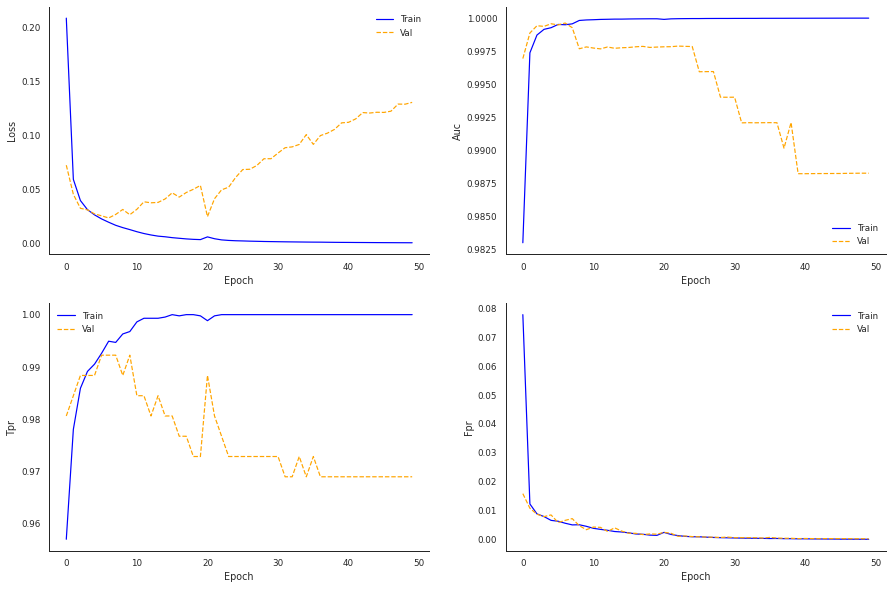

In [ ]:
# sequence 128, batch size 128
plot_metrics(history_lstm, validation=True)

## Predictions and results

In [ ]:
# get predictions for the test set
y_test_pred = (model_lstm.predict(X_test_pad) > 0.5).astype("int32")

# evaluate model on the test set
test_scores = model_lstm.evaluate(X_test_pad, y_test_pad, 
                                  sample_weight=test_sample_weights, verbose=1)

# pass scores to dictionary
dict_test_scores = {"loss": test_scores[0],
                    "tp": test_scores[1],
                    "fp": test_scores[2],
                    "tn": test_scores[3],
                    "fn": test_scores[4],
                    "auc": test_scores[5]}

23/23 [==============================] - 0s 19ms/step - loss: 0.1051 - tp: 444.0000 - fp: 26.0000 - tn: 79183.0000 - fn: 14.0000 - auc: 0.9901


In [ ]:
y_true_flat, y_pred_flat = get_flat_preds(y_test_pad, y_test_pred, pad_value=2, 
                                          remove_pad=True)

print("Length flatten LSTM test group truth {} and LSTM flatten predictions {}\n".format(y_true_flat.shape[0], y_pred_flat.shape[0]))

conf_matrix_clf_report(y_true_flat, y_pred_flat, dict_test_scores, print_info=True)

Length flatten LSTM test group truth 79667 and LSTM flatten predictions 79667

F1 score (micro): 0.957
AUC score: 0.99
TPR rate: 96.943%
FPR rate: 0.033%
BER score: 0.015
G-mean score: 0.984




,precision,recall,f1-score,support
0.0,0.999823,0.999672,0.999747,79209.000000
1.0,0.944681,0.969432,0.956897,458.000000
accuracy,0.999498,0.999498,0.999498,0.999498
macro avg,0.972252,0.984552,0.978322,79667.000000
weighted avg,0.999506,0.999498,0.999501,79667.000000


,non-fraud (pred),fraud (pred)
non-fraud (true),79183.0,26.0
fraud (true),14.0,444.0


# LSTM + initial bias

Adding the initial bias to the output layer seems to help with model overfitting, with the loss curve for the validation set being flatter compared to the previous model.

Nevetheless, the model kept the same level of TPR, around 97%, while it slighly increased FPR from .03 to 0.5

I will keep the initial bias and try to reduce the learning rate in the next step to see if it helps to reduce model overfitting (lower loss for train vs. validation), as well as to increase model generalization, mainly by increasing TPR and reducing FPR.

In [ ]:
tf.keras.backend.clear_session()

model_lstm_bias = tf.keras.Sequential()
model_lstm_bias.add(tf.keras.layers.Masking(mask_value=pad_value, 
                                            input_shape=SHAPE_LSTM_SPLIT))
model_lstm_bias.add(tf.keras.layers.LSTM(units=64, 
                                         activation="tanh",
                                         input_shape=SHAPE_LSTM_SPLIT,
                                         return_sequences=True))
model_lstm_bias.add(tf.keras.layers.Dense(64, 
                                          activation="tanh"))
model_lstm_bias.add(tf.keras.layers.Dense(1, 
                                          activation="sigmoid",
                                          bias_initializer=OUTPUT_BIAS))
model_lstm_bias.compile(loss=CustomWBCE(weight_0=CLASS_WEIGHTS[0], weight_1=CLASS_WEIGHTS[1]),
                        weighted_metrics=METRICS,
                        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,
                                                           beta_1=0.9, 
                                                           beta_2=0.999))
                                                           #clipvalue=1.))#,
                                                           #clipnorm=0.5))

model_lstm_bias.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 128, 39)           0         
                                                                 
 lstm (LSTM)                 (None, 128, 64)           26624     
                                                                 
 dense (Dense)               (None, 128, 64)           4160      
                                                                 
 dense_1 (Dense)             (None, 128, 1)            65        
                                                                 
Total params: 30,849
Trainable params: 30,849
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_lstm_bias = model_lstm_bias.fit(x=X_train_pad, 
                                        y=y_train_pad, 
                                        batch_size=128, 
                                        sample_weight=train_sample_weights, # for training data to consider sample weights to mask values
                                        epochs=100,
                                        validation_data=(X_val_pad, 
                                                         y_val_pad, 
                                                         val_sample_weights)) # for validation data to consider sample weights to mask values

Epoch 1/50
49/49 [==============================] - 15s 198ms/step - loss: 0.7049 - tp: 2843.0000 - fp: 13171.0000 - tn: 814488.0000 - fn: 1928.0000 - auc: 0.8998 - val_loss: 0.1038 - val_tp: 242.0000 - val_fp: 490.0000 - val_tn: 42840.0000 - val_fn: 15.0000 - val_auc: 0.9955
Epoch 2/50
49/49 [==============================] - 7s 141ms/step - loss: 0.0761 - tp: 4160.0000 - fp: 9533.0000 - tn: 738917.0000 - fn: 153.0000 - auc: 0.9964 - val_loss: 0.0632 - val_tp: 249.0000 - val_fp: 459.0000 - val_tn: 42871.0000 - val_fn: 8.0000 - val_auc: 0.9984
Epoch 3/50
49/49 [==============================] - 7s 140ms/step - loss: 0.0544 - tp: 4210.0000 - fp: 8029.0000 - tn: 740421.0000 - fn: 103.0000 - auc: 0.9981 - val_loss: 0.0456 - val_tp: 252.0000 - val_fp: 384.0000 - val_tn: 42946.0000 - val_fn: 5.0000 - val_auc: 0.9992
Epoch 4/50
49/49 [==============================] - 7s 142ms/step - loss: 0.0433 - tp: 4238.0000 - fp: 7196.0000 - tn: 741254.0000 - fn: 75.0000 - auc: 0.9989 - val_loss: 0.0375

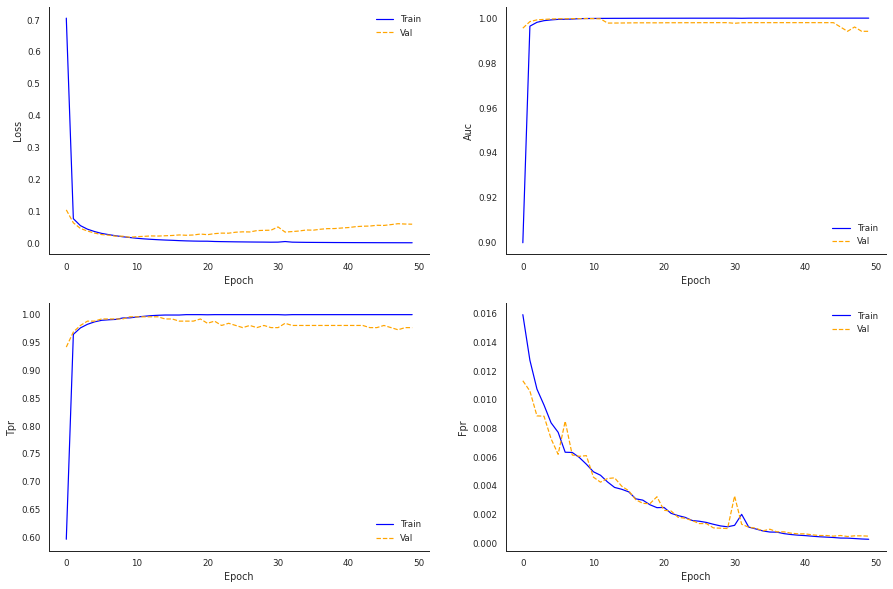

In [ ]:
# sequence 128, batch size 128
plot_metrics(history_lstm_bias, validation=True)

### Predictions and results

In [ ]:
# get predictions for the test set
y_test_pred_bias = (model_lstm_bias.predict(X_test_pad) > 0.5).astype("int32")

# evaluate model on the test set
test_scores_bias = model_lstm_bias.evaluate(X_test_pad, y_test_pad, 
                                            sample_weight=test_sample_weights, 
                                            verbose=1)

# pass scores to dictionary
dict_test_scores_bias = {"loss": test_scores_bias[0],
                         "tp": test_scores_bias[1],
                         "fp": test_scores_bias[2],
                         "tn": test_scores_bias[3],
                         "fn": test_scores_bias[4],
                         "auc": test_scores_bias[5]}

23/23 [==============================] - 0s 20ms/step - loss: 0.1003 - tp: 443.0000 - fp: 43.0000 - tn: 79166.0000 - fn: 15.0000 - auc: 0.9923


In [ ]:
# sequence 128, batch size 128
y_true_flat_bias, y_pred_flat_bias = get_flat_preds(y_test_pad, y_test_pred_bias, 
                                                    pad_value=2, 
                                                    remove_pad=True)

print("Length flatten LSTM test group truth {} and LSTM flatten predictions {}\n".format(y_true_flat_bias.shape[0], y_pred_flat_bias.shape[0]))

conf_matrix_clf_report(y_true_flat_bias, y_pred_flat_bias, dict_test_scores_bias, print_info=True)

Length flatten LSTM test group truth 79667 and LSTM flatten predictions 79667

F1 score (micro): 0.939
AUC score: 0.992
TPR rate: 96.725%
FPR rate: 0.054%
BER score: 0.017
G-mean score: 0.983




,precision,recall,f1-score,support
0.0,0.999811,0.999457,0.999634,79209.000000
1.0,0.911523,0.967249,0.938559,458.000000
accuracy,0.999272,0.999272,0.999272,0.999272
macro avg,0.955667,0.983353,0.969097,79667.000000
weighted avg,0.999303,0.999272,0.999283,79667.000000


,non-fraud (pred),fraud (pred)
non-fraud (true),79166.0,43.0
fraud (true),15.0,443.0


# LSTM + reduce learning rate

Reducing learning rate from 0.001 to 0.0001 helps to improve the loss curve for the training set, matching the one for validation loss. Moreover, in the test set it improves TRP to 98%, although it significantly increases FPR, from 0.05 to .56. This increase in FPR is also seen in the FPR curve for the validation set, in which the y-axis is composed by much higher values compared to a learning rate of .001

In the next step, I will try dropout keeping the previous learning rate (0.001) as this increase in FPR could not be sustained in following models.

In [ ]:
tf.keras.backend.clear_session()

model_lstm_lr = tf.keras.Sequential()
model_lstm_lr.add(tf.keras.layers.Masking(mask_value=pad_value, 
                                          input_shape=SHAPE_LSTM_SPLIT))
model_lstm_lr.add(tf.keras.layers.LSTM(units=64, 
                                       activation="tanh",
                                       input_shape=SHAPE_LSTM_SPLIT,
                                       return_sequences=True))
model_lstm_lr.add(tf.keras.layers.Dense(64, 
                                        activation="tanh"))
model_lstm_lr.add(tf.keras.layers.Dense(1, 
                                        activation="sigmoid",
                                        bias_initializer=OUTPUT_BIAS))
model_lstm_lr.compile(loss=CustomWBCE(weight_0=CLASS_WEIGHTS[0], weight_1=CLASS_WEIGHTS[1]),
                      weighted_metrics=METRICS,
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001,
                                                          beta_1=0.9, 
                                                          beta_2=0.999))
                                                          #clipvalue=1.))#,
                                                          #clipnorm=0.5))

model_lstm_lr.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 128, 39)           0         
                                                                 
 lstm (LSTM)                 (None, 128, 64)           26624     
                                                                 
 dense (Dense)               (None, 128, 64)           4160      
                                                                 
 dense_1 (Dense)             (None, 128, 1)            65        
                                                                 
Total params: 30,849
Trainable params: 30,849
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_lstm_lr = model_lstm_lr.fit(x=X_train_pad, 
                                    y=y_train_pad, 
                                    batch_size=128, 
                                    sample_weight=train_sample_weights, # for training data to consider sample weights to mask values
                                    epochs=50,
                                    validation_data=(X_val_pad, 
                                                    y_val_pad, 
                                                    val_sample_weights)) # for validation data to consider sample weights to mask values

Epoch 1/50
49/49 [==============================] - 14s 191ms/step - loss: 2.1180 - tp: 443.0000 - fp: 43.0000 - tn: 827616.0000 - fn: 4328.0000 - auc: 0.8905 - val_loss: 1.8239 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 43330.0000 - val_fn: 257.0000 - val_auc: 0.9633
Epoch 2/50
49/49 [==============================] - 7s 146ms/step - loss: 1.3388 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 748450.0000 - fn: 4313.0000 - auc: 0.9733 - val_loss: 1.0312 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 43330.0000 - val_fn: 257.0000 - val_auc: 0.9787
Epoch 3/50
49/49 [==============================] - 7s 145ms/step - loss: 0.6376 - tp: 1381.0000 - fp: 198.0000 - tn: 748252.0000 - fn: 2932.0000 - auc: 0.9755 - val_loss: 0.4716 - val_tp: 164.0000 - val_fp: 44.0000 - val_tn: 43286.0000 - val_fn: 93.0000 - val_auc: 0.9749
Epoch 4/50
49/49 [==============================] - 7s 146ms/step - loss: 0.3184 - tp: 3415.0000 - fp: 4568.0000 - tn: 743882.0000 - fn: 898.0000 - auc: 0.9737 - val_l

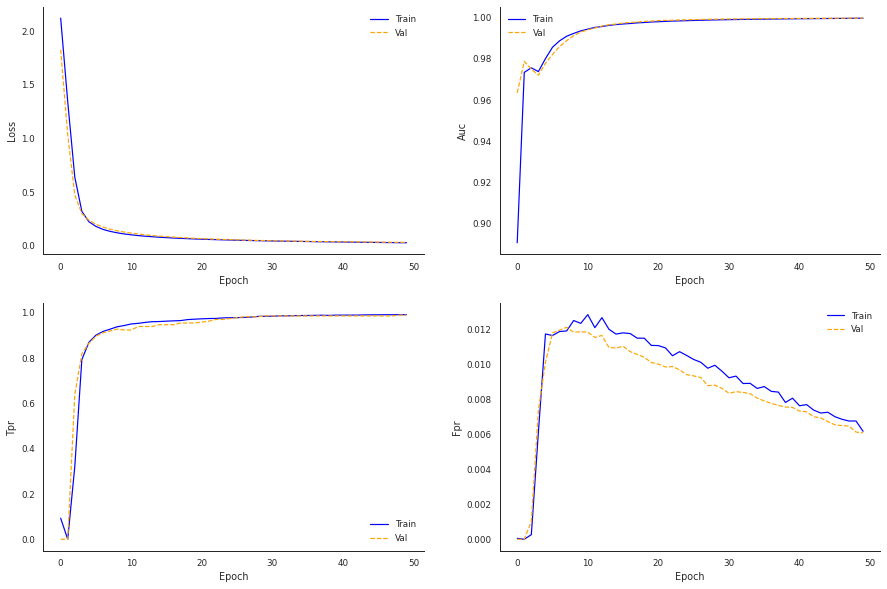

In [ ]:
# learning rate .001
plot_metrics(history_lstm_lr, validation=True)

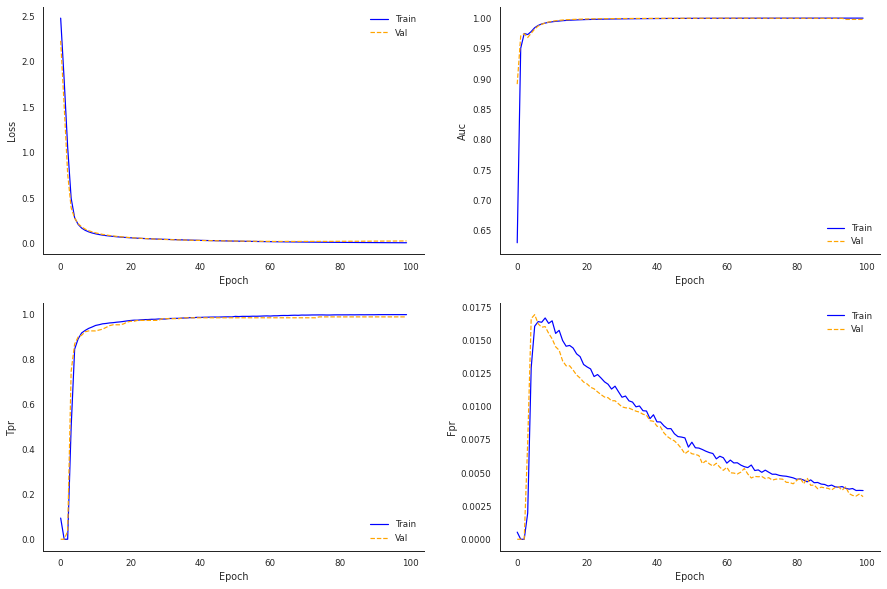

In [ ]:
# learning rate .0001
plot_metrics(history_lstm_lr, validation=True)

## Predictions and results

In [ ]:
# get predictions for the test set
y_test_pred_lr = (model_lstm_lr.predict(X_test_pad) > 0.5).astype("int32")

# evaluate model on the test set
test_scores_lr = model_lstm_lr.evaluate(X_test_pad, y_test_pad, 
                                        sample_weight=test_sample_weights, 
                                        verbose=1)

# pass scores to dictionary
dict_test_scores_lr = {"loss": test_scores_lr[0],
                       "tp": test_scores_lr[1],
                       "fp": test_scores_lr[2],
                       "tn": test_scores_lr[3],
                       "fn": test_scores_lr[4],
                       "auc": test_scores_lr[5]}

23/23 [==============================] - 0s 19ms/step - loss: 0.0301 - tp: 450.0000 - fp: 264.0000 - tn: 78945.0000 - fn: 8.0000 - auc: 0.9997


In [ ]:
# learning rate .0001
y_true_flat_lr, y_pred_flat_lr = get_flat_preds(y_test_pad, y_test_pred_lr, pad_value=2, 
                                                remove_pad=True)

print("Length flatten LSTM test group truth {} and LSTM flatten predictions {}\n".format(y_true_flat_lr.shape[0], y_pred_flat_lr.shape[0]))

conf_matrix_clf_report(y_true_flat_lr, y_pred_flat_lr, dict_test_scores_lr, print_info=True)

Length flatten LSTM test group truth 79667 and LSTM flatten predictions 79667

F1 score (micro): 0.665
AUC score: 1.0
TPR rate: 98.253%
FPR rate: 0.562%
BER score: 0.012
G-mean score: 0.988




,precision,recall,f1-score,support
0.0,0.999898,0.994382,0.997133,79209.000000
1.0,0.502793,0.982533,0.665188,458.000000
accuracy,0.994314,0.994314,0.994314,0.994314
macro avg,0.751346,0.988457,0.831161,79667.000000
weighted avg,0.997041,0.994314,0.995224,79667.000000


,non-fraud (pred),fraud (pred)
non-fraud (true),78764.0,445.0
fraud (true),8.0,450.0


# LSTM + initial bias + dropout

I can see that dropout make training and validation loss curves, as well as metrics more similar, reducing model overfitting. However, the lowest dropout rate tested (0.1) increased FPR to .16, more than double of the model without dropout. On the other hand, it increases TPR from 96.72 to 98.03.

Higher dropouts (0.2 ad 0.3) increased much more the FPR on the test set.

* *Using only dropout, that is not recurrent dropout, increased FPR much more than when both are used*

As for MLP, I could consider not to retain dropout. Nevertheless, it seems to lead to more stable model, so I will opt for keeping it in try to improve FPR with some hyperparameter tuning.

In [ ]:
dropout_value = 0.3

In [ ]:
tf.keras.backend.clear_session()

model_lstm_dropout = tf.keras.Sequential()
model_lstm_dropout.add(tf.keras.layers.Masking(mask_value=pad_value, 
                                               input_shape=SHAPE_LSTM_SPLIT))
model_lstm_dropout.add(tf.keras.layers.LSTM(units=64, 
                                            activation="tanh",
                                            input_shape=SHAPE_LSTM_SPLIT,
                                            dropout=dropout_value,
                                            recurrent_dropout=dropout_value,
                                            return_sequences=True))
model_lstm_dropout.add(tf.keras.layers.Dense(64, 
                                             activation="tanh"))
model_lstm_dropout.add(tf.keras.layers.Dense(1, 
                                             activation="sigmoid",
                                             bias_initializer=OUTPUT_BIAS))
model_lstm_dropout.compile(loss=CustomWBCE(weight_0=CLASS_WEIGHTS[0], weight_1=CLASS_WEIGHTS[1]),
                           weighted_metrics=METRICS,
                           optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,
                                                               beta_1=0.9, 
                                                               beta_2=0.999))
                                                               #clipvalue=1.))#,
                                                               #clipnorm=0.5))

model_lstm_dropout.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 128, 39)           0         
                                                                 
 lstm (LSTM)                 (None, 128, 64)           26624     
                                                                 
 dense (Dense)               (None, 128, 64)           4160      
                                                                 
 dense_1 (Dense)             (None, 128, 1)            65        
                                                                 
Total params: 30,849
Trainable params: 30,849
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_lstm_dropout = model_lstm_dropout.fit(x=X_train_pad, 
                                              y=y_train_pad, 
                                              batch_size=128, 
                                              sample_weight=train_sample_weights, # for training data to consider sample weights to mask values
                                              epochs=50,
                                              validation_data=(X_val_pad, 
                                                                y_val_pad, 
                                                                val_sample_weights)) # for validation data to consider sample weights to mask values

Epoch 1/50
49/49 [==============================] - 50s 953ms/step - loss: 1.0666 - tp: 1724.0000 - fp: 9779.0000 - tn: 738671.0000 - fn: 2589.0000 - auc: 0.6933 - val_loss: 0.1160 - val_tp: 237.0000 - val_fp: 812.0000 - val_tn: 42518.0000 - val_fn: 20.0000 - val_auc: 0.9517
Epoch 2/50
49/49 [==============================] - 11s 222ms/step - loss: 0.1047 - tp: 4018.0000 - fp: 9480.0000 - tn: 738970.0000 - fn: 295.0000 - auc: 0.9595 - val_loss: 0.0687 - val_tp: 245.0000 - val_fp: 660.0000 - val_tn: 42670.0000 - val_fn: 12.0000 - val_auc: 0.9690
Epoch 3/50
49/49 [==============================] - 10s 211ms/step - loss: 0.0788 - tp: 4119.0000 - fp: 9350.0000 - tn: 739100.0000 - fn: 194.0000 - auc: 0.9713 - val_loss: 0.0520 - val_tp: 248.0000 - val_fp: 517.0000 - val_tn: 42813.0000 - val_fn: 9.0000 - val_auc: 0.9765
Epoch 4/50
49/49 [==============================] - 10s 210ms/step - loss: 0.0688 - tp: 4149.0000 - fp: 9347.0000 - tn: 739103.0000 - fn: 164.0000 - auc: 0.9747 - val_loss: 0.

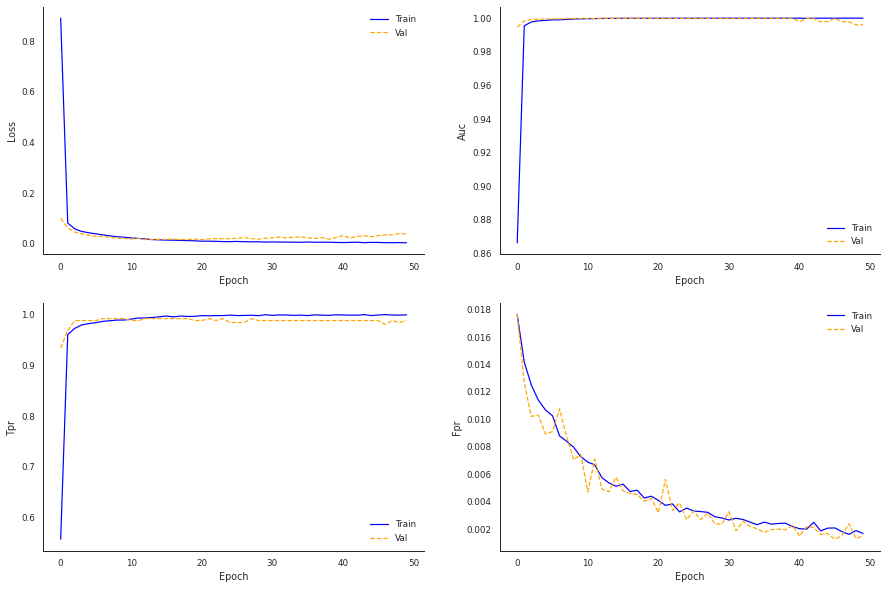

In [ ]:
# dropout 0.1
plot_metrics(history_lstm_dropout, validation=True)

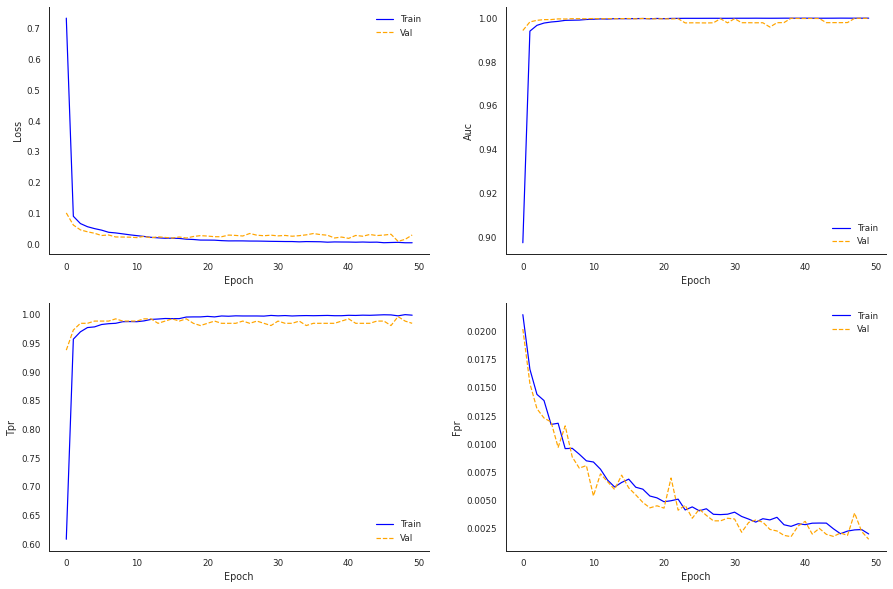

In [ ]:
# dropout 0.2
plot_metrics(history_lstm_dropout, validation=True)

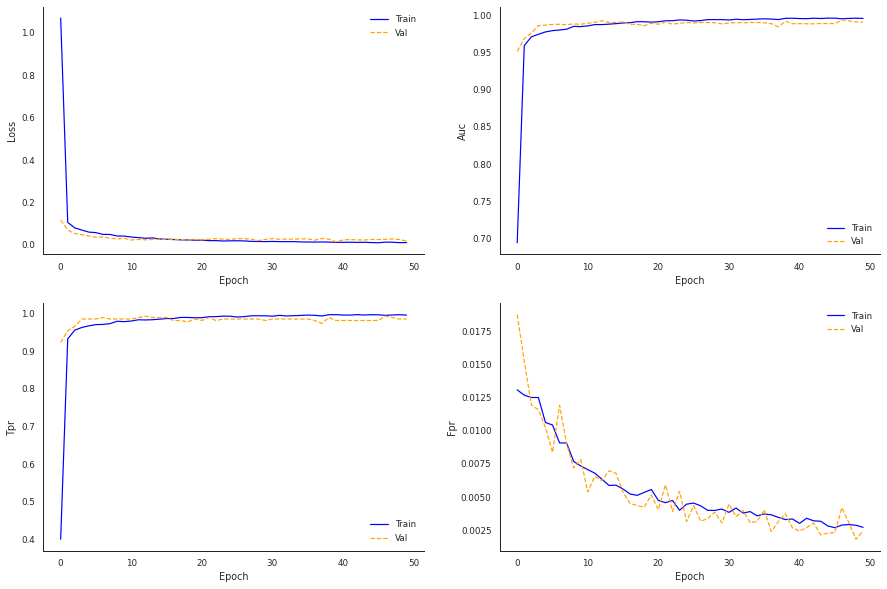

In [ ]:
# dropout 0.3
plot_metrics(history_lstm_dropout, validation=True)

## Predictions and results

In [ ]:
# get predictions for the test set
y_test_pred_dropout = (model_lstm_dropout.predict(X_test_pad) > 0.5).astype("int32")

# evaluate model on the test set
test_scores_dropout = model_lstm_dropout.evaluate(X_test_pad, y_test_pad, 
                                                  sample_weight=test_sample_weights, 
                                                  verbose=1)

# pass scores to dictionary
dict_test_scores_dropout = {"loss": test_scores_dropout[0],
                            "tp": test_scores_dropout[1],
                            "fp": test_scores_dropout[2],
                            "tn": test_scores_dropout[3],
                            "fn": test_scores_dropout[4],
                            "auc": test_scores_dropout[5]}

23/23 [==============================] - 1s 22ms/step - loss: 0.0293 - tp: 450.0000 - fp: 202.0000 - tn: 79007.0000 - fn: 8.0000 - auc: 0.9900


In [ ]:
y_true_flat_dropout, y_pred_flat_dropout = get_flat_preds(y_test_pad, y_test_pred_dropout, pad_value=2, 
                                                          remove_pad=True)

print("Length flatten LSTM test group truth {} and LSTM flatten predictions {}".format(y_true_flat_dropout.shape[0], y_pred_flat_dropout.shape[0]))

Length flatten LSTM test group truth 79667 and LSTM flatten predictions 79667


In [ ]:
# dropout 0.1
conf_matrix_clf_report(y_true_flat_dropout, y_pred_flat_dropout, dict_test_scores_dropout, print_info=True)

F1 score (micro): 0.865
AUC score: 0.998
TPR rate: 98.035%
FPR rate: 0.165%
BER score: 0.011
G-mean score: 0.989




,precision,recall,f1-score,support
0.0,0.999886,0.998346,0.999116,79209.000000
1.0,0.774138,0.980349,0.865125,458.000000
accuracy,0.998243,0.998243,0.998243,0.998243
macro avg,0.887012,0.989348,0.932120,79667.000000
weighted avg,0.998588,0.998243,0.998345,79667.000000


,non-fraud (pred),fraud (pred)
non-fraud (true),79078.0,131.0
fraud (true),9.0,449.0


In [ ]:
# dropout 0.2
conf_matrix_clf_report(y_true_flat_dropout, y_pred_flat_dropout, dict_test_scores_dropout, print_info=True)

F1 score (micro): 0.86
AUC score: 0.995
TPR rate: 98.253%
FPR rate: 0.174%
BER score: 0.01
G-mean score: 0.99




,precision,recall,f1-score,support
0.0,0.999899,0.998258,0.999078,79209.000000
1.0,0.765306,0.982533,0.860421,458.000000
accuracy,0.998167,0.998167,0.998167,0.998167
macro avg,0.882602,0.990395,0.929749,79667.000000
weighted avg,0.998550,0.998167,0.998281,79667.000000


,non-fraud (pred),fraud (pred)
non-fraud (true),79071.0,138.0
fraud (true),8.0,450.0


In [ ]:
# dropout 0.3
conf_matrix_clf_report(y_true_flat_dropout, y_pred_flat_dropout, dict_test_scores_dropout, print_info=True)

F1 score (micro): 0.773
AUC score: 0.99
TPR rate: 98.253%
FPR rate: 0.255%
BER score: 0.01
G-mean score: 0.99




,precision,recall,f1-score,support
0.0,0.999899,0.996755,0.998325,79209.000000
1.0,0.636492,0.982533,0.772532,458.000000
accuracy,0.996674,0.996674,0.996674,0.996674
macro avg,0.818195,0.989644,0.885428,79667.000000
weighted avg,0.997809,0.996674,0.997027,79667.000000


,non-fraud (pred),fraud (pred)
non-fraud (true),79007.0,202.0
fraud (true),8.0,450.0


# LSTM + recurrent regularizer

As I can see in the results, a L2 regularization gives a much more unstable FPR score, while the TPR seems to be still higher for the training compared to the validation set. In the test set, it increased the FPR to .20% and while improved the TPR from 97% to 98%

Moreover, a higher L2 regularization (0.01), helps to reduce overfitting but increases FPR to .45%. Consequently, I will not keep L2 regularization in subsequent models.

In [ ]:
l2_regularizer = tf.keras.regularizers.L2(l2=0.001)

In [ ]:
tf.keras.backend.clear_session()

model_lstm_bias_reg = tf.keras.Sequential()
model_lstm_bias_reg.add(tf.keras.layers.Masking(mask_value=pad_value, 
                                                input_shape=SHAPE_LSTM_SPLIT))
model_lstm_bias_reg.add(tf.keras.layers.LSTM(units=64, 
                                             activation="tanh",
                                             input_shape=SHAPE_LSTM_SPLIT,
                                             kernel_regularizer=l2_regularizer,
                                             return_sequences=True))
model_lstm_bias_reg.add(tf.keras.layers.Dense(64, 
                                              activation="tanh"))
model_lstm_bias_reg.add(tf.keras.layers.Dense(1, 
                                              activation="sigmoid",
                                              bias_initializer=OUTPUT_BIAS))
model_lstm_bias_reg.compile(loss=CustomWBCE(weight_0=CLASS_WEIGHTS[0], weight_1=CLASS_WEIGHTS[1]),
                            weighted_metrics=METRICS,
                            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,
                                                               beta_1=0.9, 
                                                               beta_2=0.999))
                                                               #clipvalue=1.))#,
                                                               #clipnorm=0.5))

model_lstm_bias_reg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 128, 39)           0         
                                                                 
 lstm (LSTM)                 (None, 128, 64)           26624     
                                                                 
 dense (Dense)               (None, 128, 64)           4160      
                                                                 
 dense_1 (Dense)             (None, 128, 1)            65        
                                                                 
Total params: 30,849
Trainable params: 30,849
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_lstm_bias_reg = model_lstm_bias_reg.fit(x=X_train_pad, 
                                                y=y_train_pad, 
                                                batch_size=128, 
                                                sample_weight=train_sample_weights, # for training data to consider sample weights to mask values
                                                epochs=50,
                                                validation_data=(X_val_pad, 
                                                                 y_val_pad, 
                                                                 val_sample_weights)) # for validation data to consider sample weights to mask values

Epoch 1/50
49/49 [==============================] - 16s 218ms/step - loss: 0.9004 - tp: 2598.0000 - fp: 10451.0000 - tn: 817208.0000 - fn: 2173.0000 - auc: 0.8810 - val_loss: 0.1671 - val_tp: 239.0000 - val_fp: 522.0000 - val_tn: 42808.0000 - val_fn: 18.0000 - val_auc: 0.9963
Epoch 2/50
49/49 [==============================] - 7s 148ms/step - loss: 0.1276 - tp: 4154.0000 - fp: 9559.0000 - tn: 738891.0000 - fn: 159.0000 - auc: 0.9966 - val_loss: 0.1093 - val_tp: 247.0000 - val_fp: 480.0000 - val_tn: 42850.0000 - val_fn: 10.0000 - val_auc: 0.9986
Epoch 3/50
49/49 [==============================] - 7s 149ms/step - loss: 0.0955 - tp: 4210.0000 - fp: 8317.0000 - tn: 740133.0000 - fn: 103.0000 - auc: 0.9982 - val_loss: 0.0833 - val_tp: 252.0000 - val_fp: 404.0000 - val_tn: 42926.0000 - val_fn: 5.0000 - val_auc: 0.9992
Epoch 4/50
49/49 [==============================] - 7s 149ms/step - loss: 0.0784 - tp: 4231.0000 - fp: 7577.0000 - tn: 740873.0000 - fn: 82.0000 - auc: 0.9988 - val_loss: 0.069

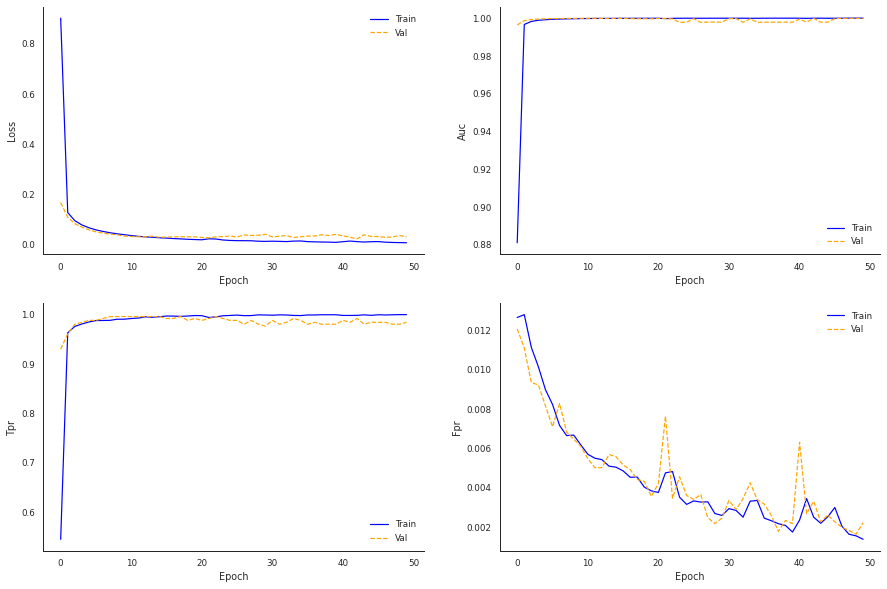

In [ ]:
# L2 = .001
plot_metrics(history_lstm_bias_reg, validation=True)

## Predictions and results

In [ ]:
# get predictions for the test set
y_test_pred_bias_reg = (model_lstm_bias_reg.predict(X_test_pad) > 0.5).astype("int32")

# evaluate model on the test set
test_scores_bias_reg = model_lstm_bias_reg.evaluate(X_test_pad, y_test_pad, 
                                                    sample_weight=test_sample_weights, 
                                                    verbose=1)

# pass scores to dictionary
dict_test_scores_bias_reg = {"loss": test_scores_bias_reg[0],
                             "tp": test_scores_bias_reg[1],
                             "fp": test_scores_bias_reg[2],
                             "tn": test_scores_bias_reg[3],
                             "fn": test_scores_bias_reg[4],
                             "auc": test_scores_bias_reg[5]}

23/23 [==============================] - 0s 20ms/step - loss: 0.0435 - tp: 448.0000 - fp: 153.0000 - tn: 79056.0000 - fn: 10.0000 - auc: 0.9976


In [ ]:
# L2 = .001
y_true_flat_bias_reg, y_pred_flat_bias_reg = get_flat_preds(y_test_pad, y_test_pred_bias_reg, pad_value=2, 
                                                                  remove_pad=True)

print("Length flatten LSTM test group truth {} and LSTM flatten predictions {}\n".format(y_true_flat_bias_reg.shape[0], y_pred_flat_bias_reg.shape[0]))

conf_matrix_clf_report(y_true_flat_bias_reg, y_pred_flat_bias_reg, dict_test_scores_bias_reg, print_info=True)

Length flatten LSTM test group truth 79667 and LSTM flatten predictions 79667

F1 score (micro): 0.846
AUC score: 0.998
TPR rate: 97.817%
FPR rate: 0.193%
BER score: 0.012
G-mean score: 0.988




,precision,recall,f1-score,support
0.0,0.999874,0.998068,0.998970,79209.000000
1.0,0.745424,0.978166,0.846081,458.000000
accuracy,0.997954,0.997954,0.997954,0.997954
macro avg,0.872649,0.988117,0.922526,79667.000000
weighted avg,0.998411,0.997954,0.998091,79667.000000


,non-fraud (pred),fraud (pred)
non-fraud (true),79056.0,153.0
fraud (true),10.0,448.0


# LSTM + kernel constraint

As another way of introduce regularization, I will try MaxNorm constraining the weights to a maximum value. In this case, I will try a value of 3, as it is one of the most applied.

In the loss plot, MaxNorm does not seem to help significantly. While the TRP for the test set increased to 98%, the FPR increased .05 points up to .10%

As the model with just the initial bias seems to be performing better, I will not use MaxNorm.

In [ ]:
tf.keras.backend.clear_session()

model_lstm_bias_maxnorm = tf.keras.Sequential()
model_lstm_bias_maxnorm.add(tf.keras.layers.Masking(mask_value=pad_value, 
                                                    input_shape=SHAPE_LSTM_SPLIT))
model_lstm_bias_maxnorm.add(tf.keras.layers.LSTM(units=64, 
                                                 activation="tanh",
                                                 input_shape=SHAPE_LSTM_SPLIT,
                                                 kernel_constraint=maxnorm(3),
                                                 return_sequences=True))
model_lstm_bias_maxnorm.add(tf.keras.layers.Dense(64, 
                                                  activation="tanh"))
model_lstm_bias_maxnorm.add(tf.keras.layers.Dense(1, 
                                                  activation="sigmoid",
                                                  bias_initializer=OUTPUT_BIAS))
model_lstm_bias_maxnorm.compile(loss=CustomWBCE(weight_0=CLASS_WEIGHTS[0], weight_1=CLASS_WEIGHTS[1]),
                                weighted_metrics=METRICS,
                                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,
                                                                   beta_1=0.9, 
                                                                   beta_2=0.999))
                                                                   #clipvalue=1.))#,
                                                                   #clipnorm=0.5))

model_lstm_bias_maxnorm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 128, 39)           0         
                                                                 
 lstm (LSTM)                 (None, 128, 64)           26624     
                                                                 
 dense (Dense)               (None, 128, 64)           4160      
                                                                 
 dense_1 (Dense)             (None, 128, 1)            65        
                                                                 
Total params: 30,849
Trainable params: 30,849
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_lstm_bias_maxnorm = model_lstm_bias_maxnorm.fit(x=X_train_pad, 
                                                        y=y_train_pad, 
                                                        batch_size=128, 
                                                        sample_weight=train_sample_weights, # for training data to consider sample weights to mask values
                                                        epochs=50,
                                                        validation_data=(X_val_pad, 
                                                                         y_val_pad, 
                                                                         val_sample_weights)) # for validation data to consider sample weights to mask values

Epoch 1/50
49/49 [==============================] - 14s 191ms/step - loss: 0.5452 - tp: 3635.0000 - fp: 16058.0000 - tn: 1147594.0000 - fn: 3257.0000 - auc: 0.9365 - val_loss: 0.0840 - val_tp: 244.0000 - val_fp: 580.0000 - val_tn: 42750.0000 - val_fn: 13.0000 - val_auc: 0.9971
Epoch 2/50
49/49 [==============================] - 7s 146ms/step - loss: 0.0706 - tp: 4164.0000 - fp: 9782.0000 - tn: 738668.0000 - fn: 149.0000 - auc: 0.9965 - val_loss: 0.0555 - val_tp: 249.0000 - val_fp: 483.0000 - val_tn: 42847.0000 - val_fn: 8.0000 - val_auc: 0.9988
Epoch 3/50
49/49 [==============================] - 7s 147ms/step - loss: 0.0522 - tp: 4214.0000 - fp: 8280.0000 - tn: 740170.0000 - fn: 99.0000 - auc: 0.9983 - val_loss: 0.0413 - val_tp: 252.0000 - val_fp: 400.0000 - val_tn: 42930.0000 - val_fn: 5.0000 - val_auc: 0.9993
Epoch 4/50
49/49 [==============================] - 7s 147ms/step - loss: 0.0423 - tp: 4236.0000 - fp: 7443.0000 - tn: 741007.0000 - fn: 77.0000 - auc: 0.9988 - val_loss: 0.0348

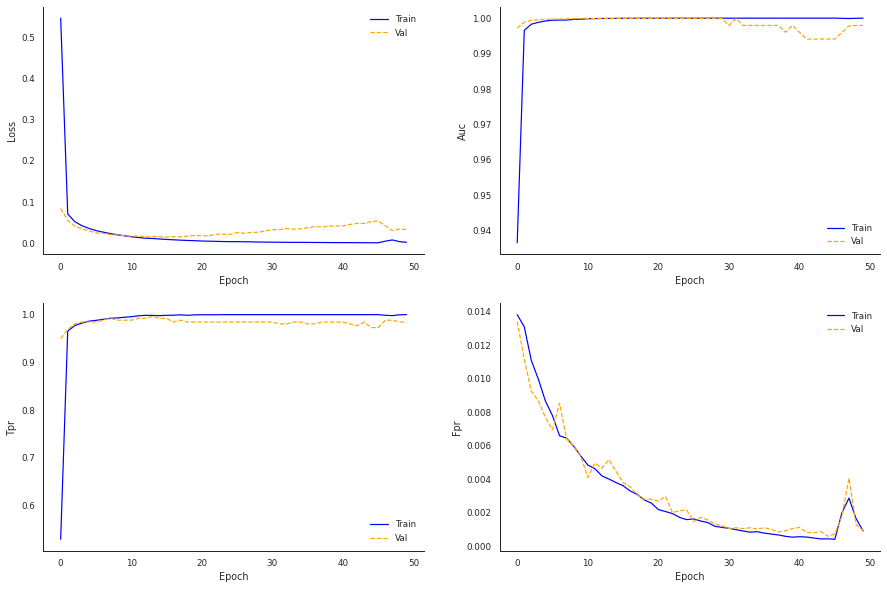

In [ ]:
plot_metrics(history_lstm_bias_maxnorm, validation=True)

## Predictions and results

In [ ]:
# get predictions for the test set
y_test_pred_bias_maxnorm = (model_lstm_bias_maxnorm.predict(X_test_pad) > 0.5).astype("int32")

# evaluate model on the test set
test_scores_bias_maxnorm = model_lstm_bias_maxnorm.evaluate(X_test_pad, y_test_pad, 
                                                            sample_weight=test_sample_weights,
                                                            verbose=1)

# pass scores to dictionary
dict_test_scores_bias_maxnorm = {"loss": test_scores_bias_maxnorm[0],
                                "tp": test_scores_bias_maxnorm[1],
                                "fp": test_scores_bias_maxnorm[2],
                                "tn": test_scores_bias_maxnorm[3],
                                "fn": test_scores_bias_maxnorm[4],
                                "auc": test_scores_bias_maxnorm[5]}

23/23 [==============================] - 0s 19ms/step - loss: 0.0396 - tp: 448.0000 - fp: 82.0000 - tn: 79127.0000 - fn: 10.0000 - auc: 0.9977


In [ ]:
y_true_flat_bias_maxnorm, y_pred_flat_bias_maxnorm = get_flat_preds(y_test_pad, y_test_pred_bias_maxnorm, pad_value=2, 
                                                                    remove_pad=True)

print("Length flatten LSTM test group truth {} and LSTM flatten predictions {}\n".format(y_true_flat_bias_maxnorm.shape[0], y_pred_flat_bias_maxnorm.shape[0]))

conf_matrix_clf_report(y_true_flat_bias_maxnorm, y_pred_flat_bias_maxnorm, dict_test_scores_bias_maxnorm, print_info=True)

Length flatten LSTM test group truth 79667 and LSTM flatten predictions 79667

F1 score (micro): 0.907
AUC score: 0.998
TPR rate: 97.817%
FPR rate: 0.104%
BER score: 0.011
G-mean score: 0.989




,precision,recall,f1-score,support
0.0,0.999874,0.998965,0.999419,79209.000000
1.0,0.845283,0.978166,0.906883,458.000000
accuracy,0.998845,0.998845,0.998845,0.998845
macro avg,0.922578,0.988565,0.953151,79667.000000
weighted avg,0.998985,0.998845,0.998887,79667.000000


,non-fraud (pred),fraud (pred)
non-fraud (true),79127.0,82.0
fraud (true),10.0,448.0


# LSTM: try different thresholds

I have decided to go with our LSTM model including the initial bias and a 0.1 dropout rate. This later regularization technique was mantained as it helped to return a more stable model. However, all of these results were using a default threshold of 0.5. 

I will try a set of thresholds from 0.1 to 0.9. Our goal is to reduce the FPR without losing too much TPR, while keeping in mind the performance of Boosting models, which I am trying to outperform.

**RESULTS**

* TPR: Thresholds from .50 to .65 return a 97.16, while between .70 and .80 a TPR of 96.72

* FPR: increasing the threshold from .50 to .80 reduce the FPR. That is, it decreases from .063 at a threshold of .50 to .031 at a threshold of .80

* Using other aggregate measures such as AUC, G-mean or BER score prioritize the TPR, as those with a better value (lower G-mean, higher BER and AUC) are those that return the highest TPR, but at a cost of increasing the FPR.

**Decision:** I will keep a threshold of .80, as it slighly reduce the TPR (Δ.44% of change in FPR; the same percentage of change is found for thresholds of .70 and .75), but the decrease in FPR is much higher, from .06 at a threshold of .50 to .03 at .80 (Δ50% of change in FPR)

In [ ]:
THRESHOLDS = [0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1]

METRICS = [tf.keras.metrics.TruePositives(name="tp", thresholds=THRESHOLDS),
           tf.keras.metrics.FalsePositives(name="fp", thresholds=THRESHOLDS),
           tf.keras.metrics.TrueNegatives(name="tn", thresholds=THRESHOLDS),
           tf.keras.metrics.FalseNegatives(name="fn", thresholds=THRESHOLDS),
           tf.keras.metrics.AUC(name="auc", curve="ROC", thresholds=THRESHOLDS)]

In [ ]:
tf.keras.backend.clear_session()

model_lstm_thresholds = tf.keras.Sequential()
model_lstm_thresholds.add(tf.keras.layers.Masking(mask_value=pad_value, 
                                                  input_shape=SHAPE_LSTM_SPLIT))
model_lstm_thresholds.add(tf.keras.layers.LSTM(units=64, 
                                               activation="tanh",
                                               input_shape=SHAPE_LSTM_SPLIT,
                                               return_sequences=True))
model_lstm_thresholds.add(tf.keras.layers.Dense(64, 
                                                activation="tanh"))
model_lstm_thresholds.add(tf.keras.layers.Dense(1, 
                                                activation="sigmoid",
                                                bias_initializer=OUTPUT_BIAS))
model_lstm_thresholds.compile(loss=CustomWBCE(weight_0=CLASS_WEIGHTS[0], weight_1=CLASS_WEIGHTS[1]),
                              weighted_metrics=METRICS,
                              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,
                                                                  beta_1=0.9, 
                                                                  beta_2=0.999))
                                                                  #clipvalue=1.))#,
                                                                  #clipnorm=0.5))

model_lstm_thresholds.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 128, 39)           0         
                                                                 
 lstm (LSTM)                 (None, 128, 64)           26624     
                                                                 
 dense (Dense)               (None, 128, 64)           4160      
                                                                 
 dense_1 (Dense)             (None, 128, 1)            65        
                                                                 
Total params: 30,849
Trainable params: 30,849
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_lstm_thresholds = model_lstm_thresholds.fit(x=X_train_pad, 
                                                    y=y_train_pad, 
                                                    batch_size=128, 
                                                    sample_weight=train_sample_weights, # for training data to consider sample weights to mask values
                                                    epochs=50,
                                                    validation_data=(X_val_pad, 
                                                                      y_val_pad, 
                                                                      val_sample_weights)) # for validation data to consider sample weights to mask values

Epoch 1/50
49/49 [==============================] - 21s 322ms/step - loss: 0.7377 - tp: 2363.4119 - fp: 24080.8828 - tn: 724369.1250 - fn: 1949.5883 - auc: 0.8277 - val_loss: 0.1014 - val_tp: 240.0000 - val_fp: 732.6470 - val_tn: 42597.3516 - val_fn: 17.0000 - val_auc: 0.9915
Epoch 2/50
49/49 [==============================] - 7s 153ms/step - loss: 0.0755 - tp: 4136.1177 - fp: 13050.5879 - tn: 735399.4375 - fn: 176.8824 - auc: 0.9930 - val_loss: 0.0617 - val_tp: 247.0588 - val_fp: 623.2353 - val_tn: 42706.7656 - val_fn: 9.9412 - val_auc: 0.9958
Epoch 3/50
49/49 [==============================] - 7s 151ms/step - loss: 0.0545 - tp: 4196.8237 - fp: 11206.3525 - tn: 737243.6250 - fn: 116.1765 - auc: 0.9948 - val_loss: 0.0465 - val_tp: 249.7647 - val_fp: 516.6470 - val_tn: 42813.3516 - val_fn: 7.2353 - val_auc: 0.9981
Epoch 4/50
49/49 [==============================] - 7s 152ms/step - loss: 0.0441 - tp: 4222.9414 - fp: 9935.7061 - tn: 738514.3125 - fn: 90.0588 - auc: 0.9955 - val_loss: 0.03

In [ ]:
# evaluate model on the test set
test_scores_thresholds = model_lstm_thresholds.evaluate(X_test_pad, y_test_pad, 
                                                        sample_weight=test_sample_weights,
                                                        verbose=1)

# store scores
dict_test_scores = {"loss": test_scores_thresholds[0],
                    "tp": dict(zip(THRESHOLDS, test_scores_thresholds[1])),
                    "fp": dict(zip(THRESHOLDS, test_scores_thresholds[2])),
                    "tn": dict(zip(THRESHOLDS, test_scores_thresholds[3])),
                    "fn": dict(zip(THRESHOLDS, test_scores_thresholds[4])),
                    "auc": test_scores_thresholds[5]} # does not support iterations for zip

23/23 [==============================] - 0s 21ms/step - loss: 0.0739 - tp: 445.0588 - fp: 58.0000 - tn: 79151.0000 - fn: 12.9412 - auc: 0.9900


In [ ]:
get_scores_thresholds(X_test_pad, y_test_pad, THRESHOLDS, model_lstm_thresholds, dict_test_scores)

Working on result for threshold: 0.9
23/23 [==============================] - 2s 18ms/step
Working on result for threshold: 0.85
23/23 [==============================] - 0s 18ms/step
Working on result for threshold: 0.8
23/23 [==============================] - 0s 19ms/step
Working on result for threshold: 0.75
23/23 [==============================] - 0s 18ms/step
Working on result for threshold: 0.7
23/23 [==============================] - 0s 19ms/step
Working on result for threshold: 0.65
23/23 [==============================] - 0s 19ms/step
Working on result for threshold: 0.6
23/23 [==============================] - 0s 18ms/step
Working on result for threshold: 0.55
23/23 [==============================] - 0s 19ms/step
Working on result for threshold: 0.5
23/23 [==============================] - 0s 18ms/step
Working on result for threshold: 0.45
23/23 [==============================] - 0s 19ms/step
Working on result for threshold: 0.4
23/23 [==============================] - 0s 19ms

,TP,FP,TN,FN,TPR,FPR,FNR,TNR,BER,G-mean,F1_micro,AUC
Threshold,,,,,,,,,,,,
0.90,440.0,18.0,79191.0,18.0,96.069866,0.022725,3.930131,99.977273,0.019764,9.800410,1.000,0.980
0.85,442.0,23.0,79186.0,16.0,96.506548,0.029037,3.493450,99.970961,0.017612,9.822348,1.000,0.982
0.80,443.0,25.0,79184.0,15.0,96.724892,0.031562,3.275109,99.968439,0.016533,9.833329,0.999,0.983
0.75,443.0,30.0,79179.0,15.0,96.724892,0.037874,3.275109,99.962127,0.016565,9.833019,0.999,0.983
0.70,443.0,34.0,79175.0,15.0,96.724892,0.042924,3.275109,99.957073,0.016590,9.832770,0.999,0.983
0.65,445.0,42.0,79167.0,13.0,97.161573,0.053024,2.838428,99.946976,0.014457,9.854443,0.999,0.986
0.60,445.0,45.0,79164.0,13.0,97.161573,0.056812,2.838428,99.943191,0.014476,9.854257,0.999,0.986
0.55,445.0,48.0,79161.0,13.0,97.161573,0.060599,2.838428,99.939400,0.014495,9.854070,0.999,0.986
0.50,445.0,50.0,79159.0,13.0,97.161573,0.063124,2.838428,99.936879,0.014508,9.853945,0.999,0.985


# LSTM: Hyperparameter tuning

I will try to improve the FPR keeping a learning rate of .001 and a dropout rate of .1. I will focus on finding the best number of units for the LSTM and Dense layers.

* *Note. I have tried tuning learning rate and dropout rate setting the minimum at .001 and .1, respectively. The search ended using a higher dropout rate, leading to in FPR but no in TPR. This is why I decided to keep the learning rate and dropout rate fixed at .001 and .1. This could be found in a section before the conclusion*

**RESULTS**

I can see that I have reduced the FPR to .07. At the same time, the TPR remains at a good level at 97.59, even higher than the two initial models.

It should be noted that the grid search was quite limited, in terms of hyperparameters, as well as the number of epochs and search trials.

In [ ]:
THRESHOLDS = [.80]

METRICS = [tf.keras.metrics.TruePositives(name="tp", thresholds=THRESHOLDS),
           tf.keras.metrics.FalsePositives(name="fp", thresholds=THRESHOLDS),
           tf.keras.metrics.TrueNegatives(name="tn", thresholds=THRESHOLDS),
           tf.keras.metrics.FalseNegatives(name="fn", thresholds=THRESHOLDS),
           tf.keras.metrics.AUC(name="auc", curve="ROC", thresholds=THRESHOLDS)]

In [ ]:
def model_lstm_hp(hp):

  # hyperparameters
  hp_units = hp.Int("units", min_value=32, max_value=128, step=16)
  #hp_dropout_rate = hp.Choice("dropout_rate", values=[0.1, 0.2, 0.3]) # there is not such a huge overfitting to try higher dropout values
  #hp_learning_rate = hp.Choice("learning_rate", values=[1e-3, 1e-4, 1e-5]) # min value for learning rate set to .001

  model_lstm_hp = tf.keras.Sequential()
  model_lstm_hp.add(tf.keras.layers.Masking(mask_value=pad_value, 
                                            input_shape=SHAPE_LSTM_SPLIT))
  model_lstm_hp.add(tf.keras.layers.LSTM(units=hp_units, 
                                         activation="tanh",
                                         input_shape=SHAPE_LSTM_SPLIT,
                                         dropout=.1,
                                         recurrent_dropout=.1,
                                         return_sequences=True))
  model_lstm_hp.add(tf.keras.layers.Dense(hp_units, 
                                          activation="tanh"))
  model_lstm_hp.add(tf.keras.layers.Dense(1, 
                                          activation="sigmoid",
                                          bias_initializer=OUTPUT_BIAS))
  model_lstm_hp.compile(loss=CustomWBCE(weight_0=CLASS_WEIGHTS[0], weight_1=CLASS_WEIGHTS[1]),
                        weighted_metrics=METRICS,
                        optimizer=tf.keras.optimizers.Adam(learning_rate=.001,
                                                           beta_1=0.9, 
                                                           beta_2=0.999))

  return model_lstm_hp

In [ ]:
tf.keras.backend.clear_session()

# select tuner
tuner_lstm = select_tuner("RandomSearch", model_lstm_hp, "tf_model_LSTM_RandomSearch_Units")

# initiate search
tuner_lstm.search(x=X_train_pad, 
                  y=y_train_pad,
                  sample_weight=train_sample_weights,
                  epochs=10, 
                  batch_size=128,
                  validation_data=(X_val_pad, y_val_pad, val_sample_weights),
                  verbose=1)

Trial 7 Complete [00h 19m 27s]
val_loss: 0.020330242812633514

Best val_loss So Far: 0.017782726635535557
Total elapsed time: 01h 24m 43s


In [ ]:
hp_names = ["units"]
best_hps = {}

for name in hp_names:
  best_hps[name] = tuner_lstm.get_best_hyperparameters()[0].get(name)
  print("Best {}: {}".format(name, tuner_lstm.get_best_hyperparameters()[0].get(name)))

Best units: 112


In [ ]:
# get the best hyperparameters
best_hps_to_train = tuner_lstm.get_best_hyperparameters()[0]

# build the model with the best hp
model_lstm_best_hps = model_lstm_hp(best_hps_to_train)

# retrain the model
history_lstm_best_hp = model_lstm_best_hps.fit(x=X_train_pad, 
                                               y=y_train_pad, 
                                               epochs=50, 
                                               batch_size=128,
                                               sample_weight=train_sample_weights,
                                               validation_data=(X_val_pad, 
                                                                y_val_pad, 
                                                                val_sample_weights))

Epoch 1/50
49/49 [==============================] - 37s 652ms/step - loss: 0.4180 - tp: 3198.0000 - fp: 6360.0000 - tn: 785420.0000 - fn: 1372.0000 - auc: 0.8459 - val_loss: 0.0666 - val_tp: 235.0000 - val_fp: 214.0000 - val_tn: 43116.0000 - val_fn: 22.0000 - val_auc: 0.9547
Epoch 2/50
49/49 [==============================] - 33s 673ms/step - loss: 0.0627 - tp: 4075.0000 - fp: 4525.0000 - tn: 743925.0000 - fn: 238.0000 - auc: 0.9694 - val_loss: 0.0466 - val_tp: 241.0000 - val_fp: 213.0000 - val_tn: 43117.0000 - val_fn: 16.0000 - val_auc: 0.9664
Epoch 3/50
49/49 [==============================] - 30s 619ms/step - loss: 0.0507 - tp: 4133.0000 - fp: 3932.0000 - tn: 744518.0000 - fn: 180.0000 - auc: 0.9765 - val_loss: 0.0374 - val_tp: 244.0000 - val_fp: 173.0000 - val_tn: 43157.0000 - val_fn: 13.0000 - val_auc: 0.9727
Epoch 4/50
49/49 [==============================] - 31s 623ms/step - loss: 0.0434 - tp: 4162.0000 - fp: 3382.0000 - tn: 745068.0000 - fn: 151.0000 - auc: 0.9802 - val_loss: 0

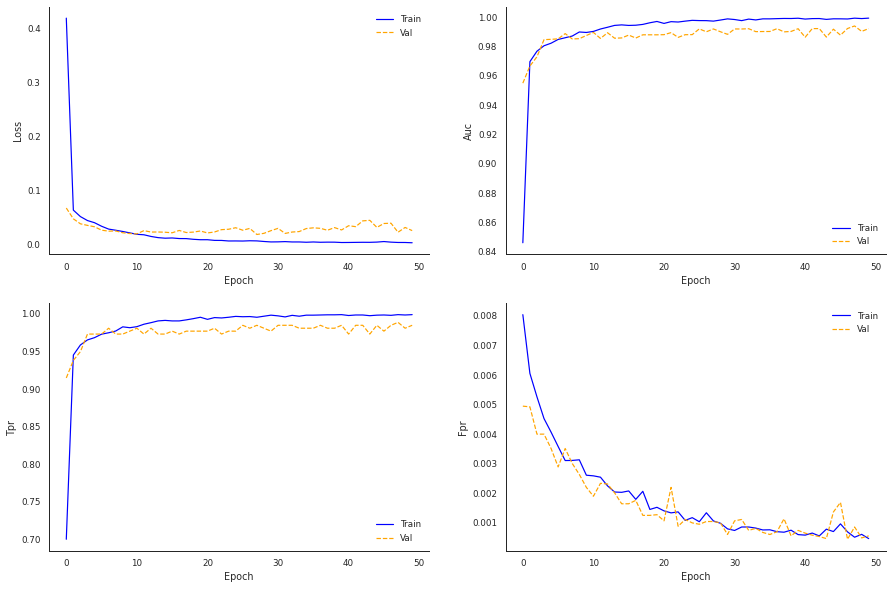

In [ ]:
# learning rate .001, dropout rate .01 and 112 hidden units
plot_metrics(history_lstm_best_hp, validation=True)

In [ ]:
# get predictions for the test set
y_test_pred_lstm_hps = (model_lstm_best_hps.predict(X_test_pad) > 0.80).astype("int32")

# evaluate model on the test set
test_scores_lstm_hps = model_lstm_best_hps.evaluate(X_test_pad, y_test_pad, 
                                                    sample_weight=test_sample_weights,
                                                    verbose=1)

# pass scores to dictionary
dict_test_scores_lstm_hps = {"loss": test_scores_lstm_hps[0],
                             "tp": test_scores_lstm_hps[1],
                             "fp": test_scores_lstm_hps[2],
                             "tn": test_scores_lstm_hps[3],
                             "fn": test_scores_lstm_hps[4],
                             "auc": test_scores_lstm_hps[5]}

23/23 [==============================] - 1s 43ms/step - loss: 0.0469 - tp: 447.0000 - fp: 60.0000 - tn: 79149.0000 - fn: 11.0000 - auc: 0.9876


In [ ]:
y_true_flat_lstm_hps, y_pred_flat_lstm_hps = get_flat_preds(y_test_pad, 
                                                            y_test_pred_lstm_hps, 
                                                            pad_value=2, 
                                                            remove_pad=True)

print("Length flatten LSTM test group truth {} and LSTM flatten predictions {}\n".format(y_true_flat_lstm_hps.shape[0], y_pred_flat_lstm_hps.shape[0]))

conf_matrix_clf_report(y_true_flat_lstm_hps, y_pred_flat_lstm_hps, 
                       dict_test_scores_lstm_hps, print_info=True)

Length flatten LSTM test group truth 79667 and LSTM flatten predictions 79667

F1 score (micro): 0.926
AUC score: 0.988
TPR rate: 97.598%
FPR rate: 0.076%
BER score: 0.012
G-mean score: 0.988




,precision,recall,f1-score,support
0.0,0.999861,0.999243,0.999552,79209.000000
1.0,0.881657,0.975983,0.926425,458.000000
accuracy,0.999109,0.999109,0.999109,0.999109
macro avg,0.940759,0.987613,0.962988,79667.000000
weighted avg,0.999181,0.999109,0.999131,79667.000000


,non-fraud (pred),fraud (pred)
non-fraud (true),79149.0,60.0
fraud (true),11.0,447.0


### Save model

In [ ]:
# save models in Colab
model_lstm_best_hps.save(os.path.join(models_path_gd, "tf_LSTM_best_hps"))
#np.save(os.path.join(models_path_gd, 'tf_LSTM_best_hps.npy'), history_lstm_best_hp.history)

### Load model

In [ ]:
model_lstm_best_hps_load = tf.keras.models.load_model(os.path.join(models_path_gd, "tf_LSTM_best_hps"), custom_objects={"CustomWBCE": CustomWBCE(CLASS_WEIGHTS[0], CLASS_WEIGHTS[1])})

### Alternative search: tuning units, dropout and learning rate

In [ ]:
hp_names = ["units", "dropout_rate", "learning_rate"]
best_hps = {}

for name in hp_names:
  best_hps[name] = tuner_lstm.get_best_hyperparameters()[0].get(name)
  print("Best {}: {}".format(name, tuner_lstm.get_best_hyperparameters()[0].get(name)))

Best units: 32
Best dropout_rate: 0.3
Best learning_rate: 0.001


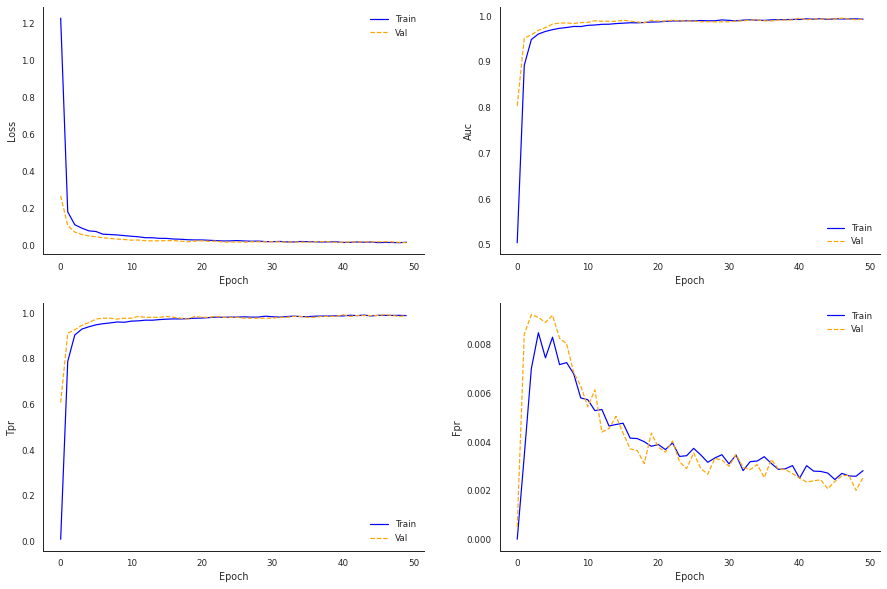

In [ ]:
plot_metrics(history_lstm_best_hp, validation=True)

In [ ]:
# get predictions for the test set
y_test_pred_lstm_hps = (model_lstm_best_hps.predict(X_test_pad) > 0.80).astype("int32")

# evaluate model on the test set
test_scores_lstm_hps = model_lstm_best_hps.evaluate(X_test_pad, y_test_pad, 
                                                    sample_weight=test_sample_weights,
                                                    verbose=1)

# pass scores to dictionary
dict_test_scores_lstm_hps = {"loss": test_scores_lstm_hps[0],
                             "tp": test_scores_lstm_hps[1],
                             "fp": test_scores_lstm_hps[2],
                             "tn": test_scores_lstm_hps[3],
                             "fn": test_scores_lstm_hps[4],
                             "auc": test_scores_lstm_hps[5]}

23/23 [==============================] - 1s 25ms/step - loss: 0.0248 - tp: 447.0000 - fp: 182.0000 - tn: 79027.0000 - fn: 11.0000 - auc: 0.9868


In [ ]:
# tuning the number of units, dropout and learning rate
y_true_flat_lstm_hps, y_pred_flat_lstm_hps = get_flat_preds(y_test_pad, 
                                                            y_test_pred_lstm_hps, 
                                                            pad_value=2, 
                                                            remove_pad=True)

print("Length flatten LSTM test group truth {} and LSTM flatten predictions {}\n".format(y_true_flat_lstm_hps.shape[0], y_pred_flat_lstm_hps.shape[0]))

conf_matrix_clf_report(y_true_flat_lstm_hps, y_pred_flat_lstm_hps, 
                       dict_test_scores_lstm_hps, print_info=True)

Length flatten LSTM test group truth 79667 and LSTM flatten predictions 79667

F1 score (micro): 0.783
AUC score: 0.987
TPR rate: 97.598%
FPR rate: 0.23%
BER score: 0.013
G-mean score: 0.987




,precision,recall,f1-score,support
0.0,0.999899,0.996957,0.998426,79209.000000
1.0,0.651230,0.982533,0.783290,458.000000
accuracy,0.996874,0.996874,0.996874,0.996874
macro avg,0.825564,0.989745,0.890858,79667.000000
weighted avg,0.997894,0.996874,0.997189,79667.000000


,non-fraud (pred),fraud (pred)
non-fraud (true),79027.0,182.0
fraud (true),11.0,447.0


# Conclusion

I can see that after tuning the number of units I was able to reduce FPR to .07 while mantaining TPR at a good level around 97. However and as stated before, a longer and more exhaustive search could lead to better model performance.

* **AUC score for LSTM (.988)** is higher than for XGBoost (.986) and LightGBM (.985), while it is lower than **MLP (.989)** 

* The result for FPR in the **LSTM model (.076)** is similar to MLP (.084), but not better than for **XGBoost (.004)**, LightGBM (.007). 

* However, **MLP offers a higher TPR (97.80)** compared to **LSTM (97.59)**, XGBoost (97.38) and LightGBM (97.20).

# Final thoughts

* I get a good and similar performance from XGBoost and LightGBM models, yet XGBoost outperforms LightGBM in all the generalization metrics.

* This better performance for XGBoost is achieved after tuning the hyperparameters and choosing a threshold of .70 instead of the default .50. This change in thresholds was focused on reducing the FPR minimazing the negative impact on the TPR.

* As I do not have much professional experience working in binary classificaiton, and specially in fraud detection, one persistent question throughout the project was if the approach chosen was the most appropriate to tune model hyperparameters. **You can see that the results are not bad, but maybe they could be improved with a different and more convenient approach.**

**FUTURE STEPS**

* **Longer training times:** due to GPU limitation in Google Colab, I have relied most of the time of CPUs, which lead to slower training times. This produced a reduction in the number of epochs for models training. Perhaps increasing training times could help model generalization, as it is known that it helps in general terms.

* **Exploring other batch sizes:** due to mean sequences length in train, test and validation sets, I chave chosen a batch size of 128. This is also supported by the notion that bigger batch sizes have a negative impact on model generalization if the learning rate is not adjusted properly.

* **Explore other model sizes and hidden units per layer:** I have selected the same number of units in the hidden layer to avoid a downsize of the data through the layers, as it is not the aim of the project. I do not want to risk losing information with this strategy.

* **Use a large hyperparameter search space (similar to XGBoost and LightGBM):** this could help to train different models and test different combinations of hyperparameters to find the one with the best performance.

* All in all, most of these points can be addressed with a good training or experience in this type of projects. This would help to establish a more rigurous methodology of model training, as well as to set the focus on the proper metrics to achieve the best performance (is it better to reduce as much as possible FPR at a cost for TPR? Should I focus on an aggregate metric such as AUC, BER or G-mean?, etc.)



### Feature importances

In [ ]:
X_train_pad.shape

(6214, 128, 39)

In [ ]:
X_test_pad.shape[0]

721

In [ ]:
# select random locations from X_train_pad.shape[0]
train_rs_loc = np.random.randint(low=0, high=X_train_pad.shape[0], size=1000)

In [ ]:
# select random locations from X_train_pad.shape[0]
test_rs_loc = np.random.randint(low=0, high=X_test_pad.shape[0], size=300)

In [ ]:
sample = []
# keep only sampled locaitons
for i in train_rs_loc:
  sample.append(X_train_pad[i])

In [ ]:
sample_test = []
# keep only sampled locaitons
for i in test_rs_loc:
  sample_test.append(X_test_pad[i])

In [ ]:
sampled_data = np.array(sample)
sampled_test_data = np.array(sample_test)
print(sampled_data.shape)
print(sampled_test_data.shape)

(1000, 128, 39)
(300, 128, 39)


In [ ]:
flat_sampled_test = []
flat_sampled_train = []

# first round of flatten sequences and predictions
for sequence in sampled_test_data:
  flat_sampled_test.append(np.ndarray.flatten(sequence))

for sequence in sampled_data:
  flat_sampled_train.append(np.ndarray.flatten(sequence))

# second round of flatten
flat_sampled_test = np.ndarray.flatten(np.array(flat_sampled_test))
flat_sampled_train = np.ndarray.flatten(np.array(flat_sampled_train))

# get mask from y_test_pad
masked_array_train = np.ma.masked_equal(flat_sampled_train, 2)
masked_array_test = np.ma.masked_equal(flat_sampled_test, 2)

# get mask from 'masked_array'
get_mask_train = np.ma.getmask(masked_array_train)
get_mask_test = np.ma.getmask(masked_array_test)

# remove mask
flat_sampled_test = np.ma.compressed(np.ma.MaskedArray(flat_sampled_test, 
                                                       mask=get_mask_test))
flat_sampled_train = np.ma.compressed(np.ma.MaskedArray(flat_sampled_train, 
                                                        mask=get_mask_train))

In [ ]:
flat_sampled_test

array([-0.8520477,  0.4217977,  1.3414892, ...,  0.       ,  0.       ,
        0.       ], dtype=float32)

In [ ]:
# use DeepExplainer
explainer = shap.DeepExplainer(model_lstm_best_hps_load, flat_sampled_train)

# get shap values
# shap_values = explainer.shap_values(sampled_data)

# # get summary bar plot
# shap.summary_plot(shap_values, sampled_test_data, 
#                   max_display=len(X_train_lstm.columns), plot_type="bar",
#                   plot_size=(15, 10))

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


AssertionError: ignored